# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part I

This notebook uses the cleaned DataFrames built off of the "NYPD Complaint Data Historic" dataset (https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i) to build a series of classification models designed to identify the most salient predictors of cannabis arrests during the period of 2006-2018 by looking at the coefficients of the best performing Logistic Regression classifier. The cleaned DataFrames contain a series of features native to the NYPD's dataset, but also contain a series of derived features (as detailed in the Data Cleaning notebooks).

The three different classification models are:


- A model classifying cannabis crimes from all other crimes in New York City (the focus of this notebook)
- A model classifying cannabis possession crimes and cannabis sales crimes
- A model classifying the five types of cannabis crime in New York City, namely misdemeanor possession, violation possession, felony possession, misdemeanor sales, and felony sales

The first model will identify the strongest predictors of cannabis arrests in contrast to all other crimes; this model uses the cleaned universe of 220,304 NYC cannabis crimes committed between 2006 and 2018 combined with a random sample of 220,304 non-cannabis crimes committed during the same time period. The second model will classify on the more general categories of possession and sales, identifying the strongest predictors of each of these more general crime categories, and will only use the cleaned universe of cannabis crimes. The third model will identify the strongest predictors that differentiate each of the five types of cannabis crimes listed above, and will also only use the cleaned universe of cannabis crimes.

The target features of the models are categorical and not continuous, so classification is the focus in this report. Because of the large sample size and feature size, the two classifier types that will be investigated are Logistic Regression and Random Forest.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1130)

A flow chart of the machine learning pipeline for classifying cannabis and non-cannabis crimes is visualized below. The final outcome of which algorithm performed best, along with the model building strategy classifying possession and sales crimes, is included in this visualization.

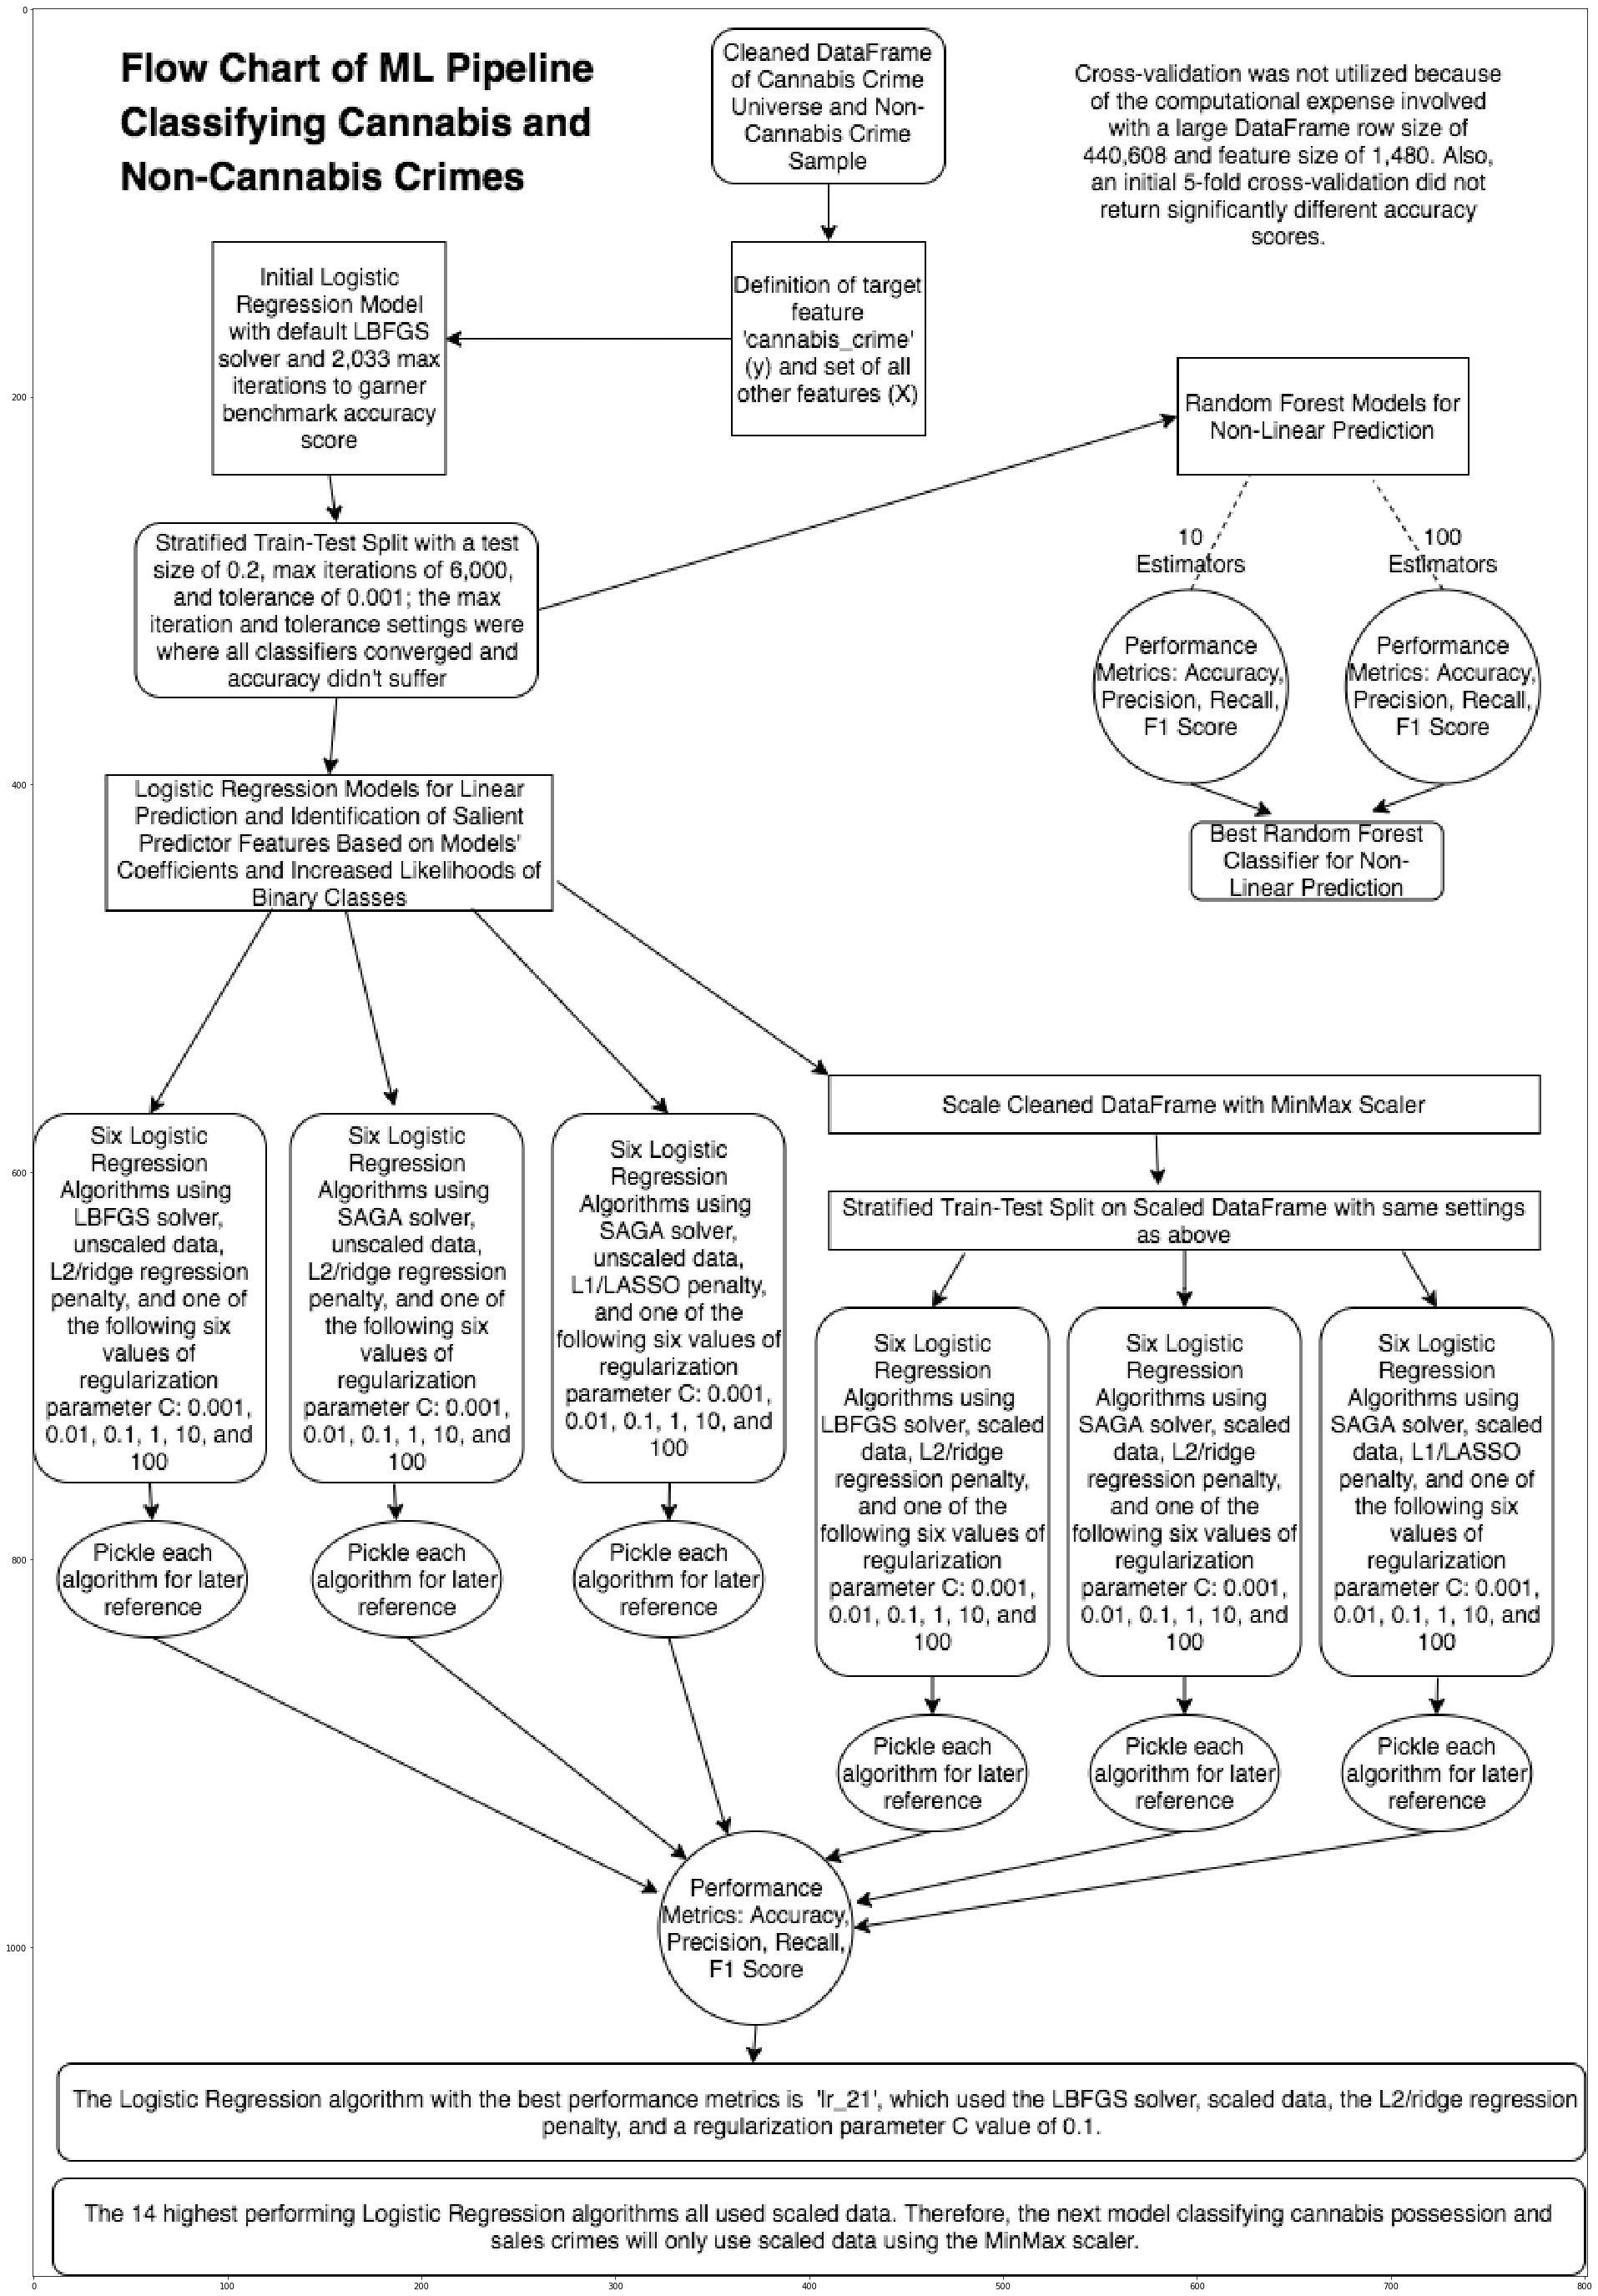

In [3]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("Cannabis vs. Non-Cannabis ML Pipeline.png")
implot = plt.imshow(im)

# Classification of Cannabis Crimes and Non-Cannabis Crimes

The concatenated DataFrame of all 220,304 cannabis crimes and the random sample of 220,304 non-cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [4]:
df = pd.read_csv('concat_cann_non_cann_for_ml.csv', index_col=0)

In [5]:
df.shape

(440608, 1481)

The cannabis crime cases have a value of '1' in the 'cannabis_crime' feature, and non-cannabis crime cases have a value of '0'.

In [6]:
df['cannabis_crime'].value_counts()

1    220304
0    220304
Name: cannabis_crime, dtype: int64

The .head() method is called on the 'df' DataFrame for reference.

In [7]:
df.head()

,ADDR_PCT_CD_1.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,HADEVELOPT_1162-1176 WASHINGTON AVENUE,HADEVELOPT_131 SAINT NICHOLAS AVENUE,HADEVELOPT_1471 WATSON AVENUE,HADEVELOPT_303 VERNON AVENUE,HADEVELOPT_33-35 SARATOGA AVENUE,HADEVELOPT_45 ALLEN STREET,HADEVELOPT_572 WARREN STREET,HADEVELOPT_830 AMSTERDAM AVENUE,HADEVELOPT_ADAMS,HADEVELOPT_ALBANY,HADEVELOPT_ALBANY II,HADEVELOPT_AMSTERDAM,HADEVELOPT_ARMSTRONG I,HADEVELOPT_ARMSTRONG II,HADEVELOPT_ASTORIA,HADEVELOPT_ATLANTIC TERMINAL SITE 4B,HADEVELOPT_AUDUBON,HADEVELOPT_BAILEY AVENUE-WEST 193RD STREET,HADEVELOPT_BAISLEY PARK,HADEVELOPT_BARUCH,HADEVELOPT_BARUCH HOUSES ADDITION,HADEVELOPT_BAY VIEW,HADEVELOPT_BAYCHESTER,HADEVELOPT_BAYSIDE-OCEAN BAY APTS,HADEVELOPT_BEACH 41ST STREET-BEACH CHANNEL DRIVE,HADEVELOPT_BEDFORD-STUYVESANT REHAB,HADEVELOPT_BELMONT-SUTTER AREA,HADEVELOPT_BERRY,HADEVELOPT_BERRY STREET-SOUTH 9TH STREET,HADEVELOPT_BETANCES I,HADEVELOPT_BETANCES III,HADEVELOPT_BETANCES VI,HADEVELOPT_BETHUNE GARDENS,HADEVELOPT_BLAND,HADEVELOPT_BORINQUEN PLAZA I,HADEVELOPT_BORINQUEN PLAZA II,HADEVELOPT_BOSTON ROAD PLAZA,HADEVELOPT_BOSTON SECOR,HADEVELOPT_BOULEVARD,HADEVELOPT_BOYNTON AVENUE REHAB,HADEVELOPT_BREUKELEN,HADEVELOPT_BREVOORT,HADEVELOPT_BRONX RIVER,HADEVELOPT_BRONX RIVER ADDITION,HADEVELOPT_BRONXDALE,HADEVELOPT_BROWN,HADEVELOPT_BROWNSVILLE,HADEVELOPT_BRYANT AVENUE-EAST 174TH STREET,HADEVELOPT_BUSHWICK,HADEVELOPT_BUSHWICK II (GROUPS A & C),HADEVELOPT_BUSHWICK II (GROUPS B & D),HADEVELOPT_BUSHWICK II CDA (GROUP E),HADEVELOPT_BUTLER,HADEVELOPT_CAMPOS PLAZA I,HADEVELOPT_CAREY GARDENS,HADEVELOPT_CARLETON MANOR,HADEVELOPT_CARVER,HADEVELOPT_CASSIDY-LAFAYETTE,HADEVELOPT_CASTLE HILL,HADEVELOPT_CLAREMONT PARKWAY-FRANKLIN AVENUE,HADEVELOPT_CLAREMONT REHAB (GROUP 2),HADEVELOPT_CLAREMONT REHAB (GROUP 3),HADEVELOPT_CLAREMONT REHAB (GROUP 4),HADEVELOPT_CLAREMONT REHAB (GROUP 5),HADEVELOPT_CLASON POINT GARDENS,HADEVELOPT_CLINTON,HADEVELOPT_COLLEGE AVENUE-EAST 165TH STREET,HADEVELOPT_CONEY ISLAND,HADEVELOPT_CONEY ISLAND I (SITE 1B),HADEVELOPT_COOPER PARK,HADEVELOPT_CROWN HEIGHTS,HADEVELOPT_CYPRESS HILLS,HADEVELOPT_DAVIDSON,HADEVELOPT_DE HOSTOS APARTMENTS,HADEVELOPT_DOUGLASS,HADEVELOPT_DOUGLASS ADDITION,HADEVELOPT_DYCKMAN,HADEVELOPT_EAGLE AVENUE-EAST 163RD STREET,HADEVELOPT_EAST 165TH STREET-BRYANT AVENUE,HADEVELOPT_EAST 173RD STREET-VYSE AVENUE,HADEVELOPT_EAST 180TH STREET-MONTEREY AVENUE,HADEVELOPT_EAST NEW YORK CITY LINE,HADEVELOPT_EASTCHESTER GARDENS,HADEVELOPT_EDENWALD,HADEVELOPT_FARRAGUT,HADEVELOPT_FENIMORE-LEFFERTS,HADEVELOPT_FIORENTINO PLAZA,HADEVELOPT_FIRST HOUSES,HADEVELOPT_FOREST,HADEVELOPT_FORT INDEPENDENCE STREET-HEATH AVENUE,HADEVEL

## Logistic Regression Classifying Cannabis Crimes and Non-Cannabis Crimes

First, a basic logistic regression model is fitted using the default solver 'lbfgs'. The number of maximum iterations for the solver was experimented with until the model converged. The score returned with the 'lbfgs' solver specified was roughly 0.835.

In [8]:
lr = linear_model.LogisticRegression(solver='lbfgs', max_iter=2033)

In [9]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2033, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

The target feature in this series of classifications is the binary feature 'cannabis_crime', with a value of 1 for cannabis crimes and 0 for non-cannabis crimes. The target feature is assigned to y.

In [10]:
y = df['cannabis_crime']

The feature set is assigned to X, which includes all features in the 'df' DataFrame which are not the target.

In [11]:
target_names = ['cannabis_crime']
X = df[[cn for cn in df.columns if cn not in target_names]]

As a starting point, a basic Logistic Regression model using the "Limited-memory Broyden-Fletcher-Goldfarb-Shanno", or "lbfgs", solver and no hyperparameter tuning is first fitted on the feature set X and the target name y.

In [12]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2033, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

The Logistic Regression model's accuracy score is returned, giving the percentage of correct predictions divided by the total number of data points. With the default maximum iterations of 100, the accuracy score was roughly 0.75. After the model converged at 2,033 iterations, it is .835. However, different combinations of hyperparameters cause convergence at different max iteration settings, so a 'max_iter' setting of 6,000 and a 'tol' value of 0.001 was ultimately decided upon for all Logistic Regression algorithms going forward.

In [13]:
lr.score(X, y)

0.8351073970513472

Of course, computing the accuracy on data with no test-train split is not indicative of the model's ability to generalize to unseen data. So the data will be split into training and test sets below, where the LogisticRegression classifier will be fit to the training set, predictions will be made on the labeled test set, and these predictions will be compared with the known test labels. The accuracy of the predictions will then be computed, and the models will be evaluated by calling its precision, recall, and F1 score, as well as by calling the Receiver Operating Characteristic (ROC) curve and its Area Under the Curve (AUC) score. For the imbalanced class classifications of possession/sales and the five cannabis crime types, the Precision Recall curve and their respective Area Under the Curve (AUC) scores will also be called. 

In tuning the hyperparameters, the 'lbfgs' and 'saga' solvers will be experimented with. The 'lbfgs' solver does not allow for the L1 penalty, otherwise known as LASSO regression. For this reason, the 'saga' solver will be experimented with later in the notebook, as it is capable of using both the L2 (i.e., ridge regression) penalty and the L1 penalty. The 'lbfgs' and 'saga' solvers will be run on both unscaled and scaled data. This is because the 'saga' solver has been shown to perform better with scaled data (https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451). For the sake of a balanced experimental design, both solvers will be run on both unscaled and scaled data.

## Training and Test Data Split Using the 'LBFGS' Solver and Unscaled Data

For this round of classifications, the 'lbfgs' solver is used and the data is unscaled. In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets, and hyperparameters are tuned to find the best model with the highest accuracy score, precision, recall, and F1 scores on the test set. The hyperparameter being tuned is C (with values of 0.001, 0.01, 0.1, 1.0, 10.0, 100.0), while the L2 ridge regression penalty remains constant. 

First, the data is split into a training and test set. We train on the training set, and test for accuracy on the test set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Multi-fold cross-validation is an important part of many machine learning models. In earlier drafts of this notebook however, doing so was prohibitively computationally expensive for running all the classifiers in five folds. Also, a simple five-fold cross-validation run in an earlier draft was found to return accuracy scores that were not meaningfully different, as shown in the following cell which calls a screenshot from that notebook. For these reasons, multi-fold cross-validation was not pursued.

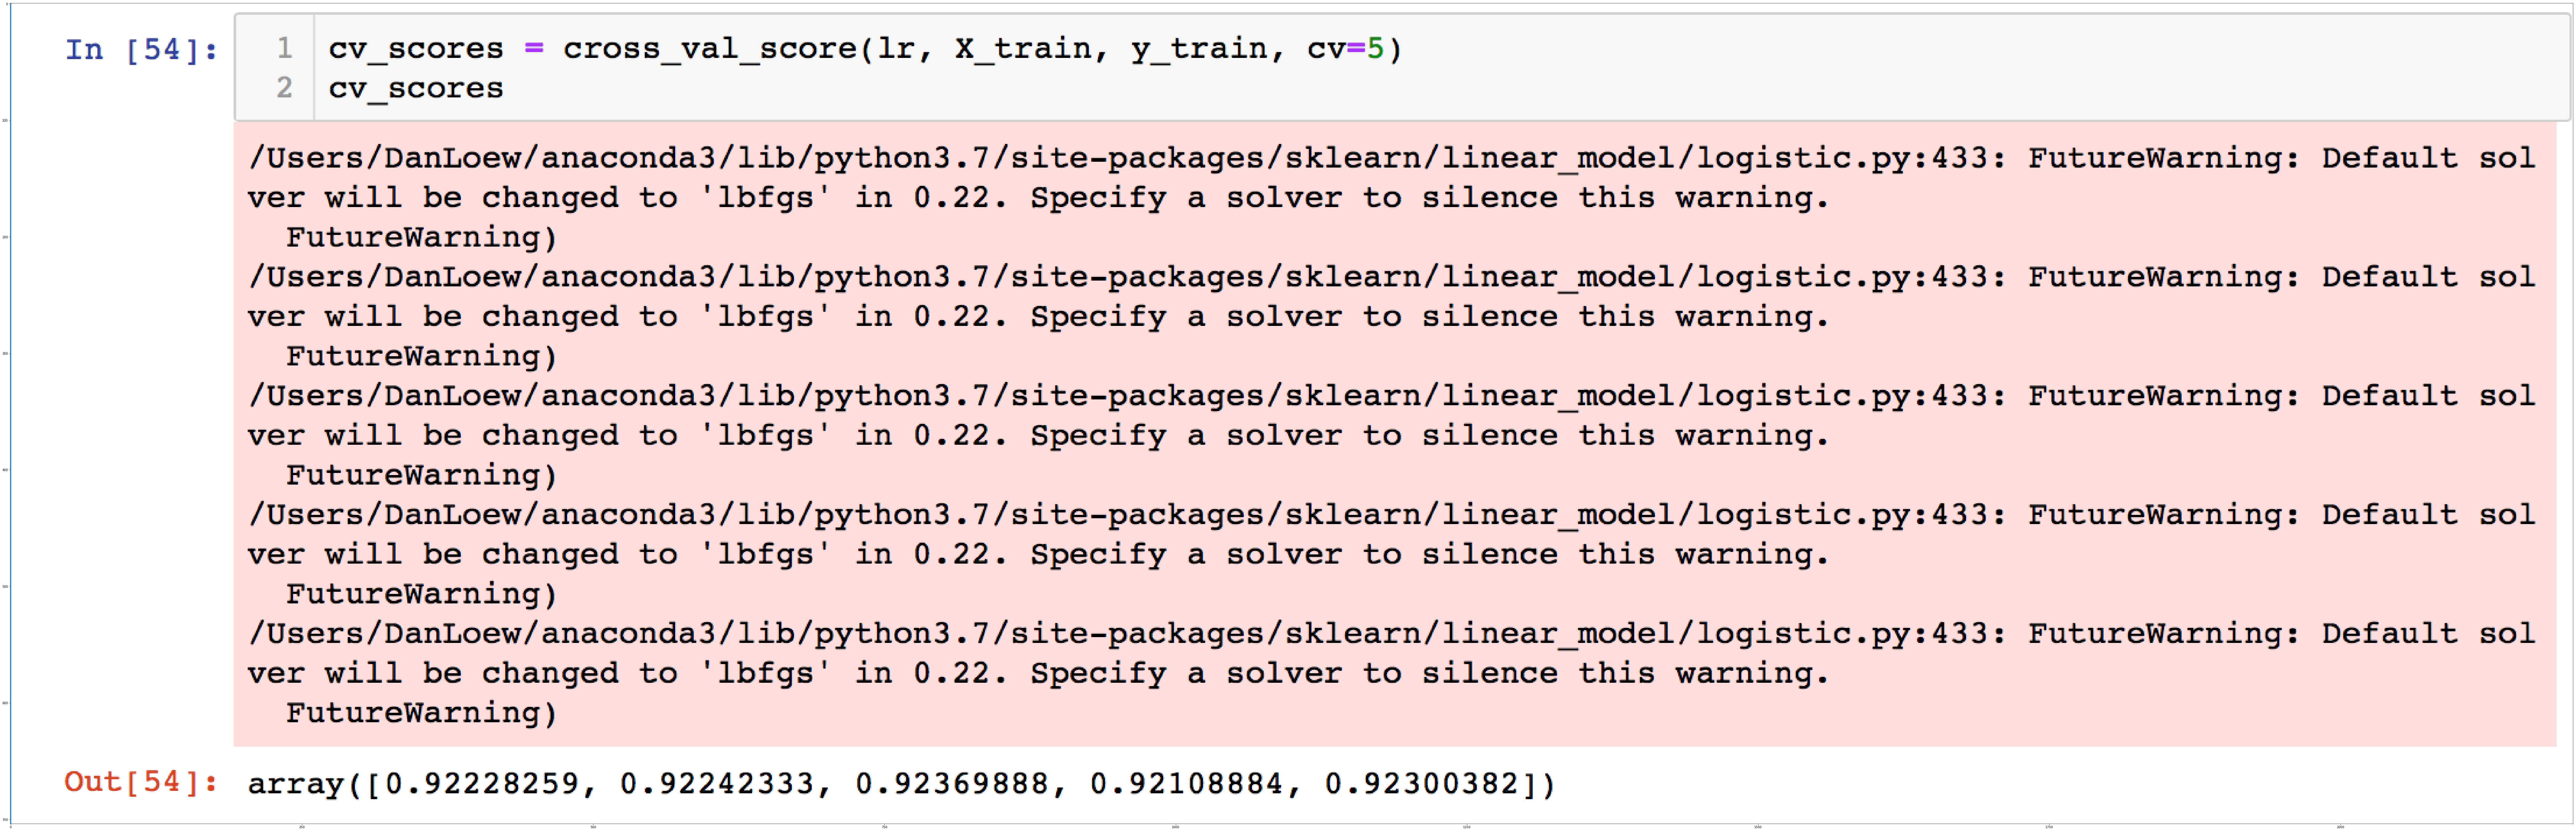

In [6]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("ML_draft_5_5-fold_CV_screenshot.png")
implot = plt.imshow(im)

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values. For each assignment of the classifier, 

a) the classifier is fitted to the training data, 

b) the target feature's values are predicted from the test feature set, 

c) the accuracy score is computed from the test set, 

d) the 'confusion_matrix' and 'classification_report' is called from the test target feature values and predicted test target values to return the precision, recall, and F1 scores, and

e) accuracy, precision, recall, and F1 scores are entered into a Hyperparameter Tuning Table in Excel, which will be read into the data space after hyperparameter tuning is resolved. 

After the best combination of hyperparameters are discovered from using the 'lbfgs' and 'saga' solvers on both unscaled and scaled data, an ROC curve and the AUC will be calculated and displayed to present a visual image of the evaluation of the best LogisticRegression model. Because the class sample sizes used in this notebook are  perfectly balanced, and Precision Recall curves are not very illustrative for balanced classes (see Dr. Brownlee's article at https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/), the Precision Recall Curve and its AUC will not be called in this notebook.

In [15]:
lr_1 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=6000, tol=0.001)

In [16]:
lr_1.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

The accuracy is also called on the training set once for reference.

In [17]:
lr_1.score(X_train, y_train)

0.8287932002973167

In [18]:
y_pred_1 = lr_1.predict(X_test)
y_pred_1[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [19]:
print(accuracy_score(y_test, y_pred_1))

0.8301786160096231


The confusion matrix shows that there are 34,704 true positives, 5,608 false positives, 9,357 false negatives, and 38,453 true negatives.

In [20]:
print(confusion_matrix(y_test, y_pred_1))

[[34704  9357]
 [ 5608 38453]]


In [21]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82     44061
           1       0.80      0.87      0.84     44061

   micro avg       0.83      0.83      0.83     88122
   macro avg       0.83      0.83      0.83     88122
weighted avg       0.83      0.83      0.83     88122



In [54]:
filename = 'c_v_nc_lr_1.sav'
pickle.dump(lr_1, open(filename, 'wb'))

In [22]:
lr_2 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001)

In [23]:
lr_2.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [24]:
y_pred_2 = lr_2.predict(X_test)
y_pred_2[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [25]:
print(accuracy_score(y_test, y_pred_2))

0.8386555003290892


The confusion matrix shows that there are 35,117 true positives, 5,274 false positives, 8,944 false negatives, and 38,787 true negatives.

In [26]:
print(confusion_matrix(y_test, y_pred_2))

[[35117  8944]
 [ 5274 38787]]


In [27]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     44061
           1       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [55]:
filename = 'c_v_nc_lr_2.sav'
pickle.dump(lr_2, open(filename, 'wb'))

In [28]:
lr_3 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001)

In [29]:
lr_3.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [30]:
y_pred_3 = lr_3.predict(X_test)
y_pred_3[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [31]:
print(accuracy_score(y_test, y_pred_3))

0.838632804521005


The confusion matrix shows that there are 35,101 true positives, 5,260 false positives, 8,960 false negatives, and 38,801 true negatives.

In [32]:
print(confusion_matrix(y_test, y_pred_3))

[[35101  8960]
 [ 5260 38801]]


In [33]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     44061
           1       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [56]:
filename = 'c_v_nc_lr_3.sav'
pickle.dump(lr_3, open(filename, 'wb'))

In [34]:
lr_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [35]:
lr_4.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [36]:
y_pred_4 = lr_4.predict(X_test)
y_pred_4[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [37]:
print(accuracy_score(y_test, y_pred_4))

0.8399264655818071


The confusion matrix shows that there are 35,166 true positives, 5,211 false positives, 8,895 false negatives, and 38,850 true negatives.

In [38]:
print(confusion_matrix(y_test, y_pred_4))

[[35166  8895]
 [ 5211 38850]]


In [39]:
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     44061
           1       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [57]:
filename = 'c_v_nc_lr_4.sav'
pickle.dump(lr_4, open(filename, 'wb'))

In [40]:
lr_5 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [41]:
lr_5.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [42]:
y_pred_5 = lr_5.predict(X_test)
y_pred_5[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [43]:
print(accuracy_score(y_test, y_pred_5))

0.8395065931322485


The confusion matrix shows that there are 35,153 true positives, 5,235 false positives, 8,908 false negatives, and 38,826 true negatives.

In [44]:
print(confusion_matrix(y_test, y_pred_5))

[[35153  8908]
 [ 5235 38826]]


In [45]:
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     44061
           1       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [58]:
filename = 'c_v_nc_lr_5.sav'
pickle.dump(lr_5, open(filename, 'wb'))

In [46]:
lr_6 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [47]:
lr_6.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [48]:
y_pred_6 = lr_6.predict(X_test)
y_pred_6[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [49]:
print(accuracy_score(y_test, y_pred_6))

0.839642767980754


The confusion matrix shows that there are 35,213 true positives, 5,283 false positives, 8,848 false negatives, and 38,778 true negatives.

In [50]:
print(confusion_matrix(y_test, y_pred_6))

[[35213  8848]
 [ 5283 38778]]


In [51]:
print(classification_report(y_test, y_pred_6))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     44061
           1       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [59]:
filename = 'c_v_nc_lr_6.sav'
pickle.dump(lr_6, open(filename, 'wb'))

## Logistic Regression Using the 'Saga' Solver and Unscaled Data

For this round of classifications, the 'saga' solver is used and the data is unscaled. In order to find the best model that can generalize to unseen data, hyperparameters are tuned to find the best model with the highest accuracy score, precision, recall, and F1 scores on the test set. These hyperparameters are C (0.001, 0.01, 0.1, 1.0, 10.0, 100.0) and the penalty (L1 LASSO regression or L2 ridge regression).  

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values. The same process is followed as was used with the 'lbfgs' solver, but this time with the 'saga' solver. 

In [60]:
lr_7 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='saga', max_iter=6000, tol=0.001)

In [61]:
lr_7.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [62]:
y_pred_7 = lr_7.predict(X_test)
y_pred_7[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [63]:
print(accuracy_score(y_test, y_pred_7))

0.798552007444225


The confusion matrix shows that there are 33,512 true positives, 7,203 false positives, 10,549 false negatives, and 36,858 true negatives.

In [64]:
print(confusion_matrix(y_test, y_pred_7))

[[33512 10549]
 [ 7203 36858]]


In [65]:
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [66]:
filename = 'c_v_nc_lr_7.sav'
pickle.dump(lr_7, open(filename, 'wb'))

In [9]:
lr_8 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='saga', max_iter=6000, tol=0.001)

In [10]:
lr_8.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [11]:
y_pred_8 = lr_8.predict(X_test)
y_pred_8[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [12]:
print(accuracy_score(y_test, y_pred_8))

0.799652754136311


The confusion matrix shows that there are 33,541 true positives, 7,135 false positives, 10,520 false negatives, and 36,926 true negatives.

In [13]:
print(confusion_matrix(y_test, y_pred_8))

[[33541 10520]
 [ 7135 36926]]


In [14]:
print(classification_report(y_test, y_pred_8))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [15]:
filename = 'c_v_nc_lr_8.sav'
pickle.dump(lr_8, open(filename, 'wb'))

In [16]:
lr_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001)

In [17]:
lr_9.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [18]:
y_pred_9 = lr_9.predict(X_test)
y_pred_9[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [19]:
print(accuracy_score(y_test, y_pred_9))

0.7998456685050271


The confusion matrix shows that there are 33,541 true positives, 7,118 false positives, 10,520 false negatives, and 36,943 true negatives.

In [20]:
print(confusion_matrix(y_test, y_pred_9))

[[33541 10520]
 [ 7118 36943]]


In [21]:
print(classification_report(y_test, y_pred_9))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [22]:
filename = 'c_v_nc_lr_9.sav'
pickle.dump(lr_9, open(filename, 'wb'))

In [23]:
lr_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001)

In [24]:
lr_10.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [25]:
y_pred_10 = lr_10.predict(X_test)
y_pred_10[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [26]:
print(accuracy_score(y_test, y_pred_10))

0.7998229726969429


The confusion matrix shows that there are 33,545 true positives, 7,124 false positives, 10,516 false negatives, and 36,937 true negatives.

In [27]:
print(confusion_matrix(y_test, y_pred_10))

[[33545 10516]
 [ 7124 36937]]


In [28]:
print(classification_report(y_test, y_pred_10))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [29]:
filename = 'c_v_nc_lr_10.sav'
pickle.dump(lr_10, open(filename, 'wb'))

In [30]:
lr_11 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='saga', max_iter=6000, tol=0.001)

In [31]:
lr_11.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [32]:
y_pred_11 = lr_11.predict(X_test)
y_pred_11[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [33]:
print(accuracy_score(y_test, y_pred_11))

0.7998683643131114


The confusion matrix shows that there are 33,543 true positives, 7,118 false positives, 10,518 false negatives, and 36,943 true negatives.

In [34]:
print(confusion_matrix(y_test, y_pred_11))

[[33543 10518]
 [ 7118 36943]]


In [35]:
print(classification_report(y_test, y_pred_11))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [36]:
filename = 'c_v_nc_lr_11.sav'
pickle.dump(lr_11, open(filename, 'wb'))

In [37]:
lr_12 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='saga', max_iter=6000, tol=0.001)

In [38]:
lr_12.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [39]:
y_pred_12 = lr_12.predict(X_test)
y_pred_12[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [40]:
print(accuracy_score(y_test, y_pred_12))

0.799834320600985


The confusion matrix shows that there are 33,545 true positives, 7,123 false positives, 10,516 false negatives, and 36,938 true negatives.

In [41]:
print(confusion_matrix(y_test, y_pred_12))

[[33545 10516]
 [ 7123 36938]]


In [42]:
print(classification_report(y_test, y_pred_12))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [43]:
filename = 'c_v_nc_lr_12.sav'
pickle.dump(lr_12, open(filename, 'wb'))

In [44]:
lr_13 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=6000, tol=0.001)

In [45]:
lr_13.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [46]:
y_pred_13 = lr_13.predict(X_test)
y_pred_13[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [47]:
print(accuracy_score(y_test, y_pred_13))

0.8007761966364813


The confusion matrix shows that there are 33,499 true positives, 6,994 false positives, 10,562 false negatives, and 37,067 true negatives.

In [48]:
print(confusion_matrix(y_test, y_pred_13))

[[33499 10562]
 [ 6994 37067]]


In [49]:
print(classification_report(y_test, y_pred_13))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79     44061
           1       0.78      0.84      0.81     44061

   micro avg       0.80      0.80      0.80     88122
   macro avg       0.80      0.80      0.80     88122
weighted avg       0.80      0.80      0.80     88122



In [50]:
filename = 'c_v_nc_lr_13.sav'
pickle.dump(lr_13, open(filename, 'wb'))

In [51]:
lr_14 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=6000, tol=0.001)

In [52]:
lr_14.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [53]:
y_pred_14 = lr_14.predict(X_test)
y_pred_14[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [54]:
print(accuracy_score(y_test, y_pred_14))

0.8078459408547242


The confusion matrix shows that there are 33,864 true positives, 6,736 false positives, 10,197 false negatives, and 37,325 true negatives.

In [55]:
print(confusion_matrix(y_test, y_pred_14))

[[33864 10197]
 [ 6736 37325]]


In [56]:
print(classification_report(y_test, y_pred_14))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     44061
           1       0.79      0.85      0.82     44061

   micro avg       0.81      0.81      0.81     88122
   macro avg       0.81      0.81      0.81     88122
weighted avg       0.81      0.81      0.81     88122



In [57]:
filename = 'c_v_nc_lr_14.sav'
pickle.dump(lr_14, open(filename, 'wb'))

In [8]:
lr_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001)

In [9]:
lr_15.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [10]:
y_pred_15 = lr_15.predict(X_test)
y_pred_15[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [11]:
print(accuracy_score(y_test, y_pred_15))

0.8085268150972515


The confusion matrix shows that there are 33,919 true positives, 6,731 false positives, 10,142 false negatives, and 37,330 true negatives.

In [12]:
print(confusion_matrix(y_test, y_pred_15))

[[33919 10142]
 [ 6731 37330]]


In [13]:
print(classification_report(y_test, y_pred_15))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     44061
           1       0.79      0.85      0.82     44061

   micro avg       0.81      0.81      0.81     88122
   macro avg       0.81      0.81      0.81     88122
weighted avg       0.81      0.81      0.81     88122



In [14]:
filename = 'c_v_nc_lr_15.sav'
pickle.dump(lr_15, open(filename, 'wb'))

In [15]:
lr_16 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=6000, tol=0.001)

In [16]:
lr_16.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [17]:
y_pred_16 = lr_16.predict(X_test)
y_pred_16[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [18]:
print(accuracy_score(y_test, y_pred_16))

0.8085949025215042


The confusion matrix shows that there are 33,925 true positives, 6,731 false positives, 10,136 false negatives, and 37,330 true negatives.

In [19]:
print(confusion_matrix(y_test, y_pred_16))

[[33925 10136]
 [ 6731 37330]]


In [20]:
print(classification_report(y_test, y_pred_16))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     44061
           1       0.79      0.85      0.82     44061

   micro avg       0.81      0.81      0.81     88122
   macro avg       0.81      0.81      0.81     88122
weighted avg       0.81      0.81      0.81     88122



In [21]:
filename = 'c_v_nc_lr_16.sav'
pickle.dump(lr_16, open(filename, 'wb'))

In [22]:
lr_17 = linear_model.LogisticRegression(penalty='l1', C=10.0, solver='saga', max_iter=6000, tol=0.001)

In [23]:
lr_17.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [24]:
y_pred_17 = lr_17.predict(X_test)
y_pred_17[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [25]:
print(accuracy_score(y_test, y_pred_17))

0.8085835546174621


The confusion matrix shows that there are 33,921 true positives, 6,728 false positives, 10,140 false negatives, and 37,333 true negatives.

In [26]:
print(confusion_matrix(y_test, y_pred_17))

[[33921 10140]
 [ 6728 37333]]


In [27]:
print(classification_report(y_test, y_pred_17))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     44061
           1       0.79      0.85      0.82     44061

   micro avg       0.81      0.81      0.81     88122
   macro avg       0.81      0.81      0.81     88122
weighted avg       0.81      0.81      0.81     88122



In [28]:
filename = 'c_v_nc_lr_17.sav'
pickle.dump(lr_17, open(filename, 'wb'))

In [29]:
lr_18 = linear_model.LogisticRegression(penalty='l1', C=100.0, solver='saga', max_iter=6000, tol=0.001)

In [30]:
lr_18.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [31]:
y_pred_18 = lr_18.predict(X_test)
y_pred_18[0:35]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [32]:
print(accuracy_score(y_test, y_pred_18))

0.8086062504255463


The confusion matrix shows that there are 33,918 true positives, 6,723 false positives, 10,143 false negatives, and 37,338 true negatives.

In [33]:
print(confusion_matrix(y_test, y_pred_18))

[[33918 10143]
 [ 6723 37338]]


In [34]:
print(classification_report(y_test, y_pred_18))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     44061
           1       0.79      0.85      0.82     44061

   micro avg       0.81      0.81      0.81     88122
   macro avg       0.81      0.81      0.81     88122
weighted avg       0.81      0.81      0.81     88122



In [35]:
filename = 'c_v_nc_lr_18.sav'
pickle.dump(lr_18, open(filename, 'wb'))

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data, for the purposes of improving the metrics when using the 'saga' solver (see https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451). The 'saga' solver is being used to investigate the effects of L1 penalties on the metrics. For the sake of a balanced investigation into finding the hyperparameters for the best performing classifier, the 'lbfgs' solver will also be run on scaled data.

In [8]:
scaler = MinMaxScaler()

In [9]:
scaler.fit(df)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

In [11]:
df_scaled.head()

,ADDR_PCT_CD_1.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,HADEVELOPT_1162-1176 WASHINGTON AVENUE,HADEVELOPT_131 SAINT NICHOLAS AVENUE,HADEVELOPT_1471 WATSON AVENUE,HADEVELOPT_303 VERNON AVENUE,HADEVELOPT_33-35 SARATOGA AVENUE,HADEVELOPT_45 ALLEN STREET,HADEVELOPT_572 WARREN STREET,HADEVELOPT_830 AMSTERDAM AVENUE,HADEVELOPT_ADAMS,HADEVELOPT_ALBANY,HADEVELOPT_ALBANY II,HADEVELOPT_AMSTERDAM,HADEVELOPT_ARMSTRONG I,HADEVELOPT_ARMSTRONG II,HADEVELOPT_ASTORIA,HADEVELOPT_ATLANTIC TERMINAL SITE 4B,HADEVELOPT_AUDUBON,HADEVELOPT_BAILEY AVENUE-WEST 193RD STREET,HADEVELOPT_BAISLEY PARK,HADEVELOPT_BARUCH,HADEVELOPT_BARUCH HOUSES ADDITION,HADEVELOPT_BAY VIEW,HADEVELOPT_BAYCHESTER,HADEVELOPT_BAYSIDE-OCEAN BAY APTS,HADEVELOPT_BEACH 41ST STREET-BEACH CHANNEL DRIVE,HADEVELOPT_BEDFORD-STUYVESANT REHAB,HADEVELOPT_BELMONT-SUTTER AREA,HADEVELOPT_BERRY,HADEVELOPT_BERRY STREET-SOUTH 9TH STREET,HADEVELOPT_BETANCES I,HADEVELOPT_BETANCES III,HADEVELOPT_BETANCES VI,HADEVELOPT_BETHUNE GARDENS,HADEVELOPT_BLAND,HADEVELOPT_BORINQUEN PLAZA I,HADEVELOPT_BORINQUEN PLAZA II,HADEVELOPT_BOSTON ROAD PLAZA,HADEVELOPT_BOSTON SECOR,HADEVELOPT_BOULEVARD,HADEVELOPT_BOYNTON AVENUE REHAB,HADEVELOPT_BREUKELEN,HADEVELOPT_BREVOORT,HADEVELOPT_BRONX RIVER,HADEVELOPT_BRONX RIVER ADDITION,HADEVELOPT_BRONXDALE,HADEVELOPT_BROWN,HADEVELOPT_BROWNSVILLE,HADEVELOPT_BRYANT AVENUE-EAST 174TH STREET,HADEVELOPT_BUSHWICK,HADEVELOPT_BUSHWICK II (GROUPS A & C),HADEVELOPT_BUSHWICK II (GROUPS B & D),HADEVELOPT_BUSHWICK II CDA (GROUP E),HADEVELOPT_BUTLER,HADEVELOPT_CAMPOS PLAZA I,HADEVELOPT_CAREY GARDENS,HADEVELOPT_CARLETON MANOR,HADEVELOPT_CARVER,HADEVELOPT_CASSIDY-LAFAYETTE,HADEVELOPT_CASTLE HILL,HADEVELOPT_CLAREMONT PARKWAY-FRANKLIN AVENUE,HADEVELOPT_CLAREMONT REHAB (GROUP 2),HADEVELOPT_CLAREMONT REHAB (GROUP 3),HADEVELOPT_CLAREMONT REHAB (GROUP 4),HADEVELOPT_CLAREMONT REHAB (GROUP 5),HADEVELOPT_CLASON POINT GARDENS,HADEVELOPT_CLINTON,HADEVELOPT_COLLEGE AVENUE-EAST 165TH STREET,HADEVELOPT_CONEY ISLAND,HADEVELOPT_CONEY ISLAND I (SITE 1B),HADEVELOPT_COOPER PARK,HADEVELOPT_CROWN HEIGHTS,HADEVELOPT_CYPRESS HILLS,HADEVELOPT_DAVIDSON,HADEVELOPT_DE HOSTOS APARTMENTS,HADEVELOPT_DOUGLASS,HADEVELOPT_DOUGLASS ADDITION,HADEVELOPT_DYCKMAN,HADEVELOPT_EAGLE AVENUE-EAST 163RD STREET,HADEVELOPT_EAST 165TH STREET-BRYANT AVENUE,HADEVELOPT_EAST 173RD STREET-VYSE AVENUE,HADEVELOPT_EAST 180TH STREET-MONTEREY AVENUE,HADEVELOPT_EAST NEW YORK CITY LINE,HADEVELOPT_EASTCHESTER GARDENS,HADEVELOPT_EDENWALD,HADEVELOPT_FARRAGUT,HADEVELOPT_FENIMORE-LEFFERTS,HADEVELOPT_FIORENTINO PLAZA,HADEVELOPT_FIRST HOUSES,HADEVELOPT_FOREST,HADEVELOPT_FORT INDEPENDENCE STREET-HEATH AVENUE,HADEVEL

The target feature 'y' is re-assigned to the binary feature 'cannabis_crime', this time with the scaled version of the DataFrame. As before, 'cannabis_crime' has a value of 1 for cannabis crimes and 0 for non-cannabis crimes.

In [12]:
y = df_scaled['cannabis_crime']

The feature set is assigned to X, which includes all features in the 'df_scaled' DataFrame which are not the target.

In [13]:
target_names = ['cannabis_crime']
X = df_scaled[[cn for cn in df_scaled.columns if cn not in target_names]]

## Training and Test Data Split Using the 'LBFGS' Solver and Scaled Data

For this round of classifications, the 'lbfgs' solver is used and the data is scaled. In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets, and hyperparameters are tuned to find the best model with the highest accuracy, precision, recall, and F1 scores on the test set. The hyperparameter being tuned is again C (with values of 0.001, 0.01, 0.1, 1.0, 10.0, 100.0), while the L2 ridge regression penalty remains constant. 

First, the data is split into a training and test set, this time with the scaled DataFrame.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values as was done with the unscaled data above.

In [43]:
lr_19 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=6000, tol=0.001)

In [44]:
lr_19.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [45]:
y_pred_19 = lr_19.predict(X_test)
y_pred_19[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [46]:
print(accuracy_score(y_test, y_pred_19))

0.8308935339642768


The confusion matrix shows that there are 34,681 true positives, 5,522 false positives, 9,380 false negatives, and 38,539 true negatives.

In [47]:
print(confusion_matrix(y_test, y_pred_19))

[[34681  9380]
 [ 5522 38539]]


In [48]:
print(classification_report(y_test, y_pred_19))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82     44061
         1.0       0.80      0.87      0.84     44061

   micro avg       0.83      0.83      0.83     88122
   macro avg       0.83      0.83      0.83     88122
weighted avg       0.83      0.83      0.83     88122



In [49]:
filename = 'c_v_nc_lr_19.sav'
pickle.dump(lr_19, open(filename, 'wb'))

In [50]:
lr_20 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001)

In [51]:
lr_20.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [52]:
y_pred_20 = lr_20.predict(X_test)
y_pred_20[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [53]:
print(accuracy_score(y_test, y_pred_20))

0.8404825128798711


The confusion matrix shows that there are 35,132 true positives, 5,128 false positives, 8,929 false negatives, and 38,933 true negatives.

In [54]:
print(confusion_matrix(y_test, y_pred_20))

[[35132  8929]
 [ 5128 38933]]


In [55]:
print(classification_report(y_test, y_pred_20))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83     44061
         1.0       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [56]:
filename = 'c_v_nc_lr_20.sav'
pickle.dump(lr_20, open(filename, 'wb'))

In [15]:
lr_21 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001)

In [16]:
lr_21.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [17]:
y_pred_21 = lr_21.predict(X_test)
y_pred_21[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [21]:
print(accuracy_score(y_test, y_pred_21))

0.8430584870974331


The confusion matrix shows that there are 35,249 true positives, 5,018 false positives, 8,812 false negatives, and 39,043 true negatives.

In [22]:
print(confusion_matrix(y_test, y_pred_21))

[[35249  8812]
 [ 5018 39043]]


In [23]:
print(classification_report(y_test, y_pred_21))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [24]:
filename = 'c_v_nc_lr_21.sav'
pickle.dump(lr_21, open(filename, 'wb'))

In [23]:
lr_22 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [24]:
lr_22.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [25]:
y_pred_22 = lr_22.predict(X_test)
y_pred_22[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [26]:
print(accuracy_score(y_test, y_pred_22))

0.8430584870974331


The confusion matrix shows that there are 35,255 true positives, 5,024 false positives, 8,806 false negatives, and 39,037 true negatives.

In [27]:
print(confusion_matrix(y_test, y_pred_22))

[[35255  8806]
 [ 5024 39037]]


In [28]:
print(classification_report(y_test, y_pred_22))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [29]:
filename = 'c_v_nc_lr_22.sav'
pickle.dump(lr_22, open(filename, 'wb'))

In [30]:
lr_23 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [31]:
lr_23.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [32]:
y_pred_23 = lr_23.predict(X_test)
y_pred_23[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [33]:
print(accuracy_score(y_test, y_pred_23))

0.842684006264043


The confusion matrix shows that there are 35,244 true positives, 5,046 false positives, 8,817 false negatives, and 39,015 true negatives.

In [34]:
print(confusion_matrix(y_test, y_pred_23))

[[35244  8817]
 [ 5046 39015]]


In [35]:
print(classification_report(y_test, y_pred_23))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [36]:
filename = 'c_v_nc_lr_23.sav'
pickle.dump(lr_23, open(filename, 'wb'))

In [37]:
lr_24 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=6000, tol=0.001)

In [38]:
lr_24.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [39]:
y_pred_24 = lr_24.predict(X_test)
y_pred_24[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [40]:
print(accuracy_score(y_test, y_pred_24))

0.8425478314155376


The confusion matrix shows that there are 35,236 true positives, 5,050 false positives, 8,825 false negatives, and 39,011 true negatives.

In [41]:
print(confusion_matrix(y_test, y_pred_24))

[[35236  8825]
 [ 5050 39011]]


In [42]:
print(classification_report(y_test, y_pred_24))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [43]:
filename = 'c_v_nc_lr_24.sav'
pickle.dump(lr_24, open(filename, 'wb'))

## Logistic Regression Using the 'Saga' Solver and Scaled Data

For this round of classifications, the 'saga' solver is used and the data is scaled. The hyperparameters used in this set of classifiers are C (with values of 0.001, 0.01, 0.1, 1.0, 10.0, 100.0), and which penalty is used (L1 LASSO regression or L2 ridge regression).

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values. The same process is followed as was used with the 'lbfgs' solver, but this time with the 'saga' solver. 

In [44]:
lr_25 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='saga', max_iter=6000, tol=0.001)

In [45]:
lr_25.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [46]:
y_pred_25 = lr_25.predict(X_test)
y_pred_25[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [47]:
print(accuracy_score(y_test, y_pred_25))

0.8308708381561926


The confusion matrix shows that there are 34,677 true positives, 5,520 false positives, 9,384 false negatives, and 38,541 true negatives.

In [48]:
print(confusion_matrix(y_test, y_pred_25))

[[34677  9384]
 [ 5520 38541]]


In [49]:
print(classification_report(y_test, y_pred_25))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82     44061
         1.0       0.80      0.87      0.84     44061

   micro avg       0.83      0.83      0.83     88122
   macro avg       0.83      0.83      0.83     88122
weighted avg       0.83      0.83      0.83     88122



In [50]:
filename = 'c_v_nc_lr_25.sav'
pickle.dump(lr_25, open(filename, 'wb'))

In [51]:
lr_26 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='saga', max_iter=6000, tol=0.001)

In [52]:
lr_26.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [53]:
y_pred_26 = lr_26.predict(X_test)
y_pred_26[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [54]:
print(accuracy_score(y_test, y_pred_26))

0.840471164975829


The confusion matrix shows that there are 35,135 true positives, 5,132 false positives, 8,926 false negatives, and 38,929 true negatives.

In [57]:
print(confusion_matrix(y_test, y_pred_26))

[[35135  8926]
 [ 5132 38929]]


In [58]:
print(classification_report(y_test, y_pred_26))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83     44061
         1.0       0.81      0.88      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [59]:
filename = 'c_v_nc_lr_26.sav'
pickle.dump(lr_26, open(filename, 'wb'))

In [60]:
lr_27 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001)

In [61]:
lr_27.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [62]:
y_pred_27 = lr_27.predict(X_test)
y_pred_27[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [63]:
print(accuracy_score(y_test, y_pred_27))

0.8430244433853067


The confusion matrix shows that there are 35,249 true positives, 5,021 false positives, 8,812 false negatives, and 39,040 true negatives.

In [64]:
print(confusion_matrix(y_test, y_pred_27))

[[35249  8812]
 [ 5021 39040]]


In [65]:
print(classification_report(y_test, y_pred_27))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [66]:
filename = 'c_v_nc_lr_27.sav'
pickle.dump(lr_27, open(filename, 'wb'))

In [67]:
lr_28 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001)

In [68]:
lr_28.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [69]:
y_pred_28 = lr_28.predict(X_test)
y_pred_28[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [70]:
print(accuracy_score(y_test, y_pred_28))

0.843047139193391


The confusion matrix shows that there are 35,255 true positives, 5,025 false positives, 8,806 false negatives, and 39,036 true negatives.

In [71]:
print(confusion_matrix(y_test, y_pred_28))

[[35255  8806]
 [ 5025 39036]]


In [72]:
print(classification_report(y_test, y_pred_28))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [73]:
filename = 'c_v_nc_lr_28.sav'
pickle.dump(lr_28, open(filename, 'wb'))

In [74]:
lr_29 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='saga', max_iter=6000, tol=0.001)

In [75]:
lr_29.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [76]:
y_pred_29 = lr_29.predict(X_test)
y_pred_29[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [77]:
print(accuracy_score(y_test, y_pred_29))

0.8427861374004222


The confusion matrix shows that there are 35,248 true positives, 5,041 false positives, 8,813 false negatives, and 39,020 true negatives.

In [78]:
print(confusion_matrix(y_test, y_pred_29))

[[35248  8813]
 [ 5041 39020]]


In [79]:
print(classification_report(y_test, y_pred_29))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [80]:
filename = 'c_v_nc_lr_29.sav'
pickle.dump(lr_29, open(filename, 'wb'))

In [81]:
lr_30 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='saga', max_iter=6000, tol=0.001)

In [82]:
lr_30.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [83]:
y_pred_30 = lr_30.predict(X_test)
y_pred_30[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [84]:
print(accuracy_score(y_test, y_pred_30))

0.8426499625519167


The confusion matrix shows that there are 35,243 true positives, 5,048 false positives, 8,818 false negatives, and 39,013 true negatives.

In [85]:
print(confusion_matrix(y_test, y_pred_30))

[[35243  8818]
 [ 5048 39013]]


In [86]:
print(classification_report(y_test, y_pred_30))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [87]:
filename = 'c_v_nc_lr_30.sav'
pickle.dump(lr_30, open(filename, 'wb'))

In [88]:
lr_31 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=6000, tol=0.001)

In [89]:
lr_31.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [90]:
y_pred_31 = lr_31.predict(X_test)
y_pred_31[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [91]:
print(accuracy_score(y_test, y_pred_31))

0.8181952293411406


The confusion matrix shows that there are 34,066 true positives, 6,026 false positives, 9,995 false negatives, and 38,035 true negatives.

In [92]:
print(confusion_matrix(y_test, y_pred_31))

[[34066  9995]
 [ 6026 38035]]


In [93]:
print(classification_report(y_test, y_pred_31))

              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81     44061
         1.0       0.79      0.86      0.83     44061

   micro avg       0.82      0.82      0.82     88122
   macro avg       0.82      0.82      0.82     88122
weighted avg       0.82      0.82      0.82     88122



In [94]:
filename = 'c_v_nc_lr_31.sav'
pickle.dump(lr_31, open(filename, 'wb'))

In [95]:
lr_32 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=6000, tol=0.001)

In [96]:
lr_32.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [97]:
y_pred_32 = lr_32.predict(X_test)
y_pred_32[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [98]:
print(accuracy_score(y_test, y_pred_32))

0.8374072308844557


The confusion matrix shows that there are 34,908 true positives, 5,175 false positives, 9,153 false negatives, and 38,886 true negatives.

In [99]:
print(confusion_matrix(y_test, y_pred_32))

[[34908  9153]
 [ 5175 38886]]


In [100]:
print(classification_report(y_test, y_pred_32))

              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83     44061
         1.0       0.81      0.88      0.84     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [101]:
filename = 'c_v_nc_lr_32.sav'
pickle.dump(lr_32, open(filename, 'wb'))

In [102]:
lr_33 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001)

In [103]:
lr_33.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [104]:
y_pred_33 = lr_33.predict(X_test)
y_pred_33[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [105]:
print(accuracy_score(y_test, y_pred_33))

0.8422868296225687


The confusion matrix shows that there are 35,189 true positives, 5,026 false positives, 8,872 false negatives, and 39,035 true negatives.

In [106]:
print(confusion_matrix(y_test, y_pred_33))

[[35189  8872]
 [ 5026 39035]]


In [107]:
print(classification_report(y_test, y_pred_33))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.81      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [108]:
filename = 'c_v_nc_lr_33.sav'
pickle.dump(lr_33, open(filename, 'wb'))

In [109]:
lr_34 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=6000, tol=0.001)

In [110]:
lr_34.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [111]:
y_pred_34 = lr_34.predict(X_test)
y_pred_34[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [112]:
print(accuracy_score(y_test, y_pred_34))

0.8429903996731803


The confusion matrix shows that there are 35,236 true positives, 5,011 false positives, 8,825 false negatives, and 39,050 true negatives.

In [113]:
print(confusion_matrix(y_test, y_pred_34))

[[35236  8825]
 [ 5011 39050]]


In [114]:
print(classification_report(y_test, y_pred_34))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [115]:
filename = 'c_v_nc_lr_34.sav'
pickle.dump(lr_34, open(filename, 'wb'))

In [116]:
lr_35 = linear_model.LogisticRegression(penalty='l1', C=10.0, solver='saga', max_iter=6000, tol=0.001)

In [117]:
lr_35.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [118]:
y_pred_35 = lr_35.predict(X_test)
y_pred_35[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [119]:
print(accuracy_score(y_test, y_pred_35))

0.8428542248246749


The confusion matrix shows that there are 35,255 true positives, 5,042 false positives, 8,806 false negatives, and 39,019 true negatives.

In [120]:
print(confusion_matrix(y_test, y_pred_35))

[[35255  8806]
 [ 5042 39019]]


In [121]:
print(classification_report(y_test, y_pred_35))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [122]:
filename = 'c_v_nc_lr_35.sav'
pickle.dump(lr_35, open(filename, 'wb'))

In [123]:
lr_36 = linear_model.LogisticRegression(penalty='l1', C=100.0, solver='saga', max_iter=6000, tol=0.001)

In [124]:
lr_36.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [125]:
y_pred_36 = lr_36.predict(X_test)
y_pred_36[0:35]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1.])

In [126]:
print(accuracy_score(y_test, y_pred_36))

0.8427293978802115


The confusion matrix shows that there are 35,252 true positives, 5,050 false positives, 8,809 false negatives, and 39,011 true negatives.

In [127]:
print(confusion_matrix(y_test, y_pred_36))

[[35252  8809]
 [ 5050 39011]]


In [128]:
print(classification_report(y_test, y_pred_36))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.84     44061
         1.0       0.82      0.89      0.85     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.85      0.84      0.84     88122
weighted avg       0.85      0.84      0.84     88122



In [129]:
filename = 'c_v_nc_lr_36.sav'
pickle.dump(lr_36, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'lr_21', the LogisticRegression algorithm using scaled data, the 'lbfgs' solver, the L2 penalty, and a C value of 0.1.

## Random Forest Algorithm

It is always a good idea to investigate one other type of classifier when doing machine learning classification. Random Forest is a good choice, as it has been found to be very useful with datasets with large sample and feature sizes, where the feature size is smaller than the sample size. For these reasons, a Random Forest classifier is carried out below, first with the default ten estimators, and then with 100 estimators.

In [130]:
rfc_1 = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [131]:
rfc_pred_1 = rfc_1.predict(X_test)

In [132]:
accuracy_score(y_test, rfc_pred_1)

0.8361022219196115

The confusion matrix shows that there are 37,465 true positives, 7,847 false positives, 6,596 false negatives, and 36,214 true negatives.

In [133]:
confusion_matrix(y_test, rfc_pred_1)

array([[37465,  6596],
       [ 7847, 36214]])

In [134]:
print(classification_report(y_test, rfc_pred_1))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     44061
         1.0       0.85      0.82      0.83     44061

   micro avg       0.84      0.84      0.84     88122
   macro avg       0.84      0.84      0.84     88122
weighted avg       0.84      0.84      0.84     88122



In [135]:
filename = 'c_v_nc_rfc_1.sav'
pickle.dump(rfc_1, open(filename, 'wb'))

In [24]:
rfc_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [25]:
rfc_pred_2 = rfc_2.predict(X_test)

In [26]:
accuracy_score(y_test, rfc_pred_2)

0.8554390504073898

The confusion matrix shows that there are 37,059 true positives, 5,737 false positives, 7,002 false negatives, and 38,324 true negatives.

In [27]:
confusion_matrix(y_test, rfc_pred_2)

array([[37059,  7002],
       [ 5737, 38324]])

In [28]:
print(classification_report(y_test, rfc_pred_2))

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85     44061
         1.0       0.85      0.87      0.86     44061

   micro avg       0.86      0.86      0.86     88122
   macro avg       0.86      0.86      0.86     88122
weighted avg       0.86      0.86      0.86     88122



In [141]:
filename = 'c_v_nc_rfc_2.sav'
pickle.dump(rfc_2, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis and Non-Cannabis Crimes

Overall, the best performing classification algorithm is the Random Forest classifier with 100 estimators, although it can't be used to find the most predictive features differentiating cannabis crimes from non-cannabis crimes as it is a non-linear algorithm without the informative coefficients that Logistic Regression has. The hyper-parameter tuning table that was created throughout this notebook is loaded and displayed below for reference. The table is sorted with the best performing classification algorithms at top, in descending order.

In [29]:
cann_v_non_cann_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Cann_v_non_Cann')
cann_v_non_cann_metrics

,Unnamed: 0,LR_#,Accuracy_Score,Precision_Non_Cann,Precision_Cann,Precision_Average,Recall_Non_Cann,Recall_Cann,Recall_Average,F1_Score_Non_Cann,F1_Score_Cann,F1_Score_Average,Support_Non_Cann,Support_Cann,Support_Total
0,"RF, scaled, 100 n_estimators","rfc_2, 100 estimators",0.856188,0.87,0.85,0.86,0.84,0.87,0.86,0.85,0.86,0.86,44061,44061,88122
1,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",21,0.843058,0.88,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
2,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",22,0.843058,0.88,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
3,"LR, scaled, saga solver, L2 penalty, C=1.0",28,0.843047,0.88,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
4,"LR, scaled, saga solver, L2 penalty, C=0.1",27,0.843024,0.88,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
5,"LR, scaled, saga solver, L1 penalty, C=1.0",34,0.842990,0.88,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
6,"LR, scaled, saga solver, L1 penalty, C=10.0",35,0.842854,0.87,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
7,"LR, scaled, saga solver, L2 penalty, C=10.0",29,0.842786,0.87,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
8,"LR, scaled, saga solver, L1 penalty, C=100.0",36,0.842729,0.87,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122
9,"LR, scaled, lbfgs solver, L2 penalty, C=10.0",23,0.842684,0.87,0.82,0.84,0.80,0.89,0.84,0.84,0.85,0.84,44061,44061,88122


## ROC curve and AUC

The ROC curves and AUCs for the Random Forest classifier with 100 estimators and the best Logistic Regression classifier ('lr_21') are called to further evaluate these algorithms.

ROC curves help to compare models that predict probabilities for two-class problems. They use the predicted probabilities of each crime as being a cannabis crime (the 1 class) or a non-cannabis crime (the 0 class), while calibrating the threshold of how to interpret these predicted probabilities as belonging to the 1 class or the 0 class, while also reducing false positive or false negative errors in prediction. 

As shown below, ROC curves plot the false positive rate on the X-axis and the true positive rate on the Y-axis for a series of candidate threshold values between 0 and 1, so small values on the X-axis indicate lower false positives and higher true negatives, while larger values on the y-axis indicate higher true positives and lower false negatives. In this case, the area under the curve (AUC) summarizes the skill of the model in predicting cannabis crimes or non-cannabis crimes. A skillful model assigns a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. This explanation of ROC curves and their AUC is provided for clarification purposes, and is a distillation of Dr. Jason Brownlee's article on the subject at https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. 

First, the ROC curve for the 'lr_21' Logistic Regression model is calculated and plotted, and its AUC score is returned.

In [19]:
y_pred_prob = lr_21.predict_proba(X_test)[:,1]
y_pred_prob

array([0.39824259, 0.8933196 , 0.93694281, ..., 0.91638232, 0.57131673,
       0.043464  ])

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr, tpr, thresholds

(array([0.00000000e+00, 2.26958081e-05, 6.80874243e-05, ...,
        9.85565466e-01, 9.85565466e-01, 1.00000000e+00]),
 array([0.       , 0.       , 0.       , ..., 0.9999773, 1.       ,
        1.       ]),
 array([1.99688814e+00, 9.96888140e-01, 9.96282185e-01, ...,
        1.00538970e-04, 1.00369322e-04, 1.60857226e-06]))

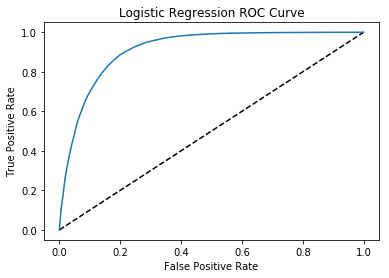

In [21]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [22]:
auc_score_lr_21 = roc_auc_score(y_test, y_pred_prob)
auc_score_lr_21

0.912587819136158

Next, the ROC curve for the RandomForest model with 100 estimators is calculated and plotted, and its AUC score is returned.

In [30]:
y_pred_prob_rfc_2 = rfc_2.predict_proba(X_test)[:,1]
y_pred_prob_rfc_2

array([0.33, 0.95, 0.94, ..., 0.81, 0.2 , 0.13])

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr, tpr, thresholds

(array([0.00000000e+00, 2.26958081e-05, 6.80874243e-05, ...,
        9.85565466e-01, 9.85565466e-01, 1.00000000e+00]),
 array([0.       , 0.       , 0.       , ..., 0.9999773, 1.       ,
        1.       ]),
 array([1.99688814e+00, 9.96888140e-01, 9.96282185e-01, ...,
        1.00538970e-04, 1.00369322e-04, 1.60857226e-06]))

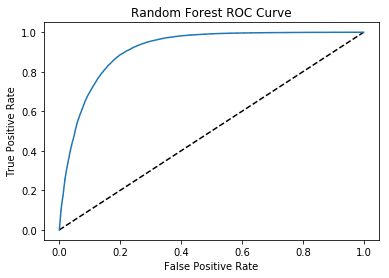

In [32]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show();

In [33]:
auc_score_rf_2 = roc_auc_score(y_test, y_pred_prob_rfc_2)
auc_score_rf_2

0.9241559999008555

## Evaluation of the Classification Models

The best LogisticRegression model ('lr_21') has an accuracy of 0.843058487097433, showing that it makes correct predictions on roughly 84.3% of the data points in the DataFrame. 

The model's precision is 0.82 for the cannabis crime class (the 1 class), 0.88 for the non-cannabis crime class (the 0 class), and 0.84 on average, showing that 82% of predicted cannabis crimes are actual cannabis crimes, 88% of predicted non-cannabis crimes are actual non-cannabis crimes, and 84% of crimes on weighted average are predicted correctly. 

The model's recall is 0.89 for the cannabis crime class (the 1 class), 0.80 for the non-cannabis crime class (the 0 class), and 0.84 on average, showing that 89% of actual cannabis crimes are predicted cannabis crimes, 80% of actual non-cannabis crimes are predicted non-cannabis crimes, and again that 84% of crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.85 for the cannabis crime class, 0.84 for the non-cannabis crime class, and 0.84 on average. This metric is more informative than precision or recall alone, and shows that 85% of cannabis crimes and 84% of non-cannabis crimes are being predicted correctly, for an average of 84%.

The ROC curves plotted above show that the best LogisticRegression model ('lr_21') has an AUC score of 91.3%, showing that it is a very skillful model in predicting cannabis crimes at a much higher rate than random. Using this model's coefficients can reliably show the features in the NYPD's dataset that have the strongest statistical relationship with cannabis crimes as differentiated from all other crimes for the time period of 2006-2018.

The RandomForest model with 100 estimators has an accuracy of 0.85618801207417. It has a 0.85 precision score for the cannabis crime class, a 0.87 precision score for the non-cannabis crime class, and an average precision score of 0.86. It has a recall score of 0.87 for the cannabis crime class, a 0.84 recall score for the non-cannabis crime class, and an average recall score of 0.86. It has a 0.86 F1 score for the cannabis crime class, a 0.85 F1 score for the non-cannabis crime class, and an average F1 score of 0.86. The ROC curve plotted above shows that it has an AUC score of 92.4%. Therefore, this is a very skillful model and one that is slightly more skillful than the best LogisticRegression model detailed above. It can be used to predict future crimes as being cannabis related or not, but because of its non-linear nature cannot uncover the features in the NYPD's dataset that have the strongest relationship with cannabis crimes. 

## Coefficients

In order to look at the most salient predictors of cannabis crimes differentiated from all other crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('lr_21') are identified to find the most predictive features differentiating cannabis crimes from all other  crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_coeffs' (short for 'best classifier's coefficients').

In [18]:
best_cf_coeffs = pd.Series(lr_21.coef_[0], index=X.columns) 
best_cf_coeffs

ADDR_PCT_CD_1.0                                          -0.342684
ADDR_PCT_CD_10.0                                          0.162349
ADDR_PCT_CD_100.0                                         0.902965
ADDR_PCT_CD_101.0                                         0.171081
ADDR_PCT_CD_102.0                                        -0.777569
ADDR_PCT_CD_103.0                                         0.458155
ADDR_PCT_CD_104.0                                        -0.178081
ADDR_PCT_CD_105.0                                        -0.189285
ADDR_PCT_CD_106.0                                        -0.367141
ADDR_PCT_CD_107.0                                        -0.315253
ADDR_PCT_CD_108.0                                         0.026666
ADDR_PCT_CD_109.0                                        -0.894667
ADDR_PCT_CD_110.0                                        -0.040085
ADDR_PCT_CD_111.0                                         0.210569
ADDR_PCT_CD_112.0                                        -0.52

The features' coefficients are then sorted to show the features most predictive of cannabis crimes and non-cannabis crimes. The features with positive coefficients are more predictive of cannabis crimes, while the features with negative coefficients are more predictive of non-cannabis crimes.

In [19]:
sorted_best_cf_coeffs = best_cf_coeffs.sort_values()
sorted_best_cf_coeffs

SUSP_AGE_GROUP_cleaned_unknown                                                      -2.694486
PREM_TYP_DESC_DEPARTMENT STORE                                                      -2.535826
PREM_TYP_DESC_CHAIN STORE                                                           -2.289986
PREM_TYP_DESC_DRUG STORE                                                            -1.840030
PREM_TYP_DESC_CLOTHING/BOUTIQUE                                                     -1.776890
SUSP_SEX_cleaned_F                                                                  -1.690422
PREM_TYP_DESC_FOOD SUPERMARKET                                                      -1.437881
PREM_TYP_DESC_GYM/FITNESS FACILITY                                                  -1.303919
ADDR_PCT_CD_94.0                                                                    -1.212568
christmas                                                                           -1.132688
morn_rush_hr                                                

Although causality for cannabis arrests cannot be attributed to them, the best Logistic Regression model's coefficients can show us which features have a strong relationship with cannabis crimes. Although there are surely a host of interactions between individual features within the feature set, for the sake of exploring which features have the strongest relationship with cannabis crime, it is assumed that they are independent of each other. With the assumption that we treat the Logistic Regression model as having no interaction terms, what the coefficients for binary features can illuminate is that if a binary feature has a value of 1, there is a certain increased likelihood that a crime will be a cannabis crime, highlighting its relationship to cannabis crime itself. 

For example, if a crime was committed on a park or playground (as denoted by the feature 'PREM_TYP_DESC_PARK/PLAYGROUND'), there is a 2.750705 unit increase in the log odds of it being a cannabis crime. When log odds are converted to odds, this 2.750705 unit increase is exponentiated to reveal a 15.65% increase in the odds of it being a cannabis crime (as discussed in the highly informative UCLA FAQ on interpreting odds ratios in Logistic Regression, available at https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/). This 15.65% odds increase shows that cannabis crimes often occur in parks and playgrounds, and have a strong relationship with these premises which differentiates them from all other crimes.

For continuous features like the hour the crime complaint was made or its L1 latitude/longitude distance to the Williamsburg bridge, for each unit increase in the continuous feature there is an increase in the odds that a crime is a cannabis crime.

To look at which features have the strongest relationship to cannabis crime, the features that have at least a 0.699809 coefficient are called and speculated on below by assigning the object 'cannabis_coeffs'. When exponentiated by assigning the object 'cannabis_coeffs_lls' ('ll' for "likelihoods"), these features are shown to provide at least a 2% increase in the odds of a crime being a cannabis crime.

This approach will be carried out in the other machine learning notebooks that explore the relationships of the feature set with cannabis possession crimes as differentiated from cannabis sales crimes, as well as for the five types of cannabis crime (e.g., misdemeanor possession, violation possession, felony possession, misdemeanor sales, and felony sales).

In [20]:
park_playground_likelihood = np.exp(2.750705)
park_playground_likelihood

15.653663827969778

In [21]:
cannabis_coeffs = sorted_best_cf_coeffs[-41:].sort_values(ascending=False)
cannabis_coeffs

PREM_TYP_DESC_PARK/PLAYGROUND                2.750705
SUSP_SEX_cleaned_unknown                     2.503232
rpt_cmplnt_dt_match                          2.421702
PREM_TYP_DESC_PUBLIC BUILDING                2.175136
start_hour                                   2.060715
PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING     1.918234
PREM_TYP_DESC_STREET                         1.638925
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)         1.638471
PREM_TYP_DESC_unknown                        1.578844
PREM_TYP_DESC_OTHER                          1.444732
SUSP_AGE_GROUP_cleaned_18-24                 1.433508
PREM_TYP_DESC_MARINA/PIER                    1.345239
PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)    1.333381
ADDR_PCT_CD_71.0                             1.207783
HADEVELOPT_WILLIAMSBURG                      1.206887
HADEVELOPT_BORINQUEN PLAZA II                1.195160
will_bridge_l1                               1.166208
PREM_TYP_DESC_PUBLIC SCHOOL                  1.118733
ADDR_PCT_CD_75.0            

In [22]:
cannabis_coeffs_lls = np.array(np.exp(cannabis_coeffs))
cannabis_coeffs_lls

array([15.65366584, 12.22192914, 11.26501905,  8.80338353,  7.85158555,
        6.80892305,  5.14962925,  5.14729561,  4.8493472 ,  4.24071434,
        4.1933856 ,  3.8391022 ,  3.79384749,  3.34605678,  3.34306063,
        3.30408496,  3.20979681,  3.06097214,  2.99494816,  2.94160604,
        2.89122616,  2.79236815,  2.70017191,  2.66518322,  2.64643375,
        2.58487908,  2.55929905,  2.54220634,  2.51898833,  2.46690596,
        2.40915584,  2.26689282,  2.25745002,  2.24876523,  2.21344838,
        2.20910666,  2.16269687,  2.15673538,  2.14427351,  2.05664452,
        2.01336883])

## Feature Set Coefficients and Likelihoods

The features, their coefficients, and the increased likelihood towards cannabis crime are called in an Excel table below.

In [23]:
cann_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='Cann_Coeffs')
cann_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Cannabis Class
0,PREM_TYP_DESC_PARK/PLAYGROUND,2.750705,15.653666
1,SUSP_SEX_cleaned_unknown,2.503232,12.221929
2,rpt_cmplnt_dt_match,2.421702,11.265019
3,PREM_TYP_DESC_PUBLIC BUILDING,2.175136,8.803384
4,start_hour,2.060715,7.851586
5,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,1.918234,6.808923
6,PREM_TYP_DESC_STREET,1.638925,5.149629
7,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),1.638471,5.147296
8,PREM_TYP_DESC_unknown,1.578844,4.849347
9,PREM_TYP_DESC_OTHER,1.444732,4.240714


The specific premises features with the highest coefficients show that cannabis arrests have the strongest relationship with parks and playgrounds, public housing buildings, the street, and open areas or lots. All of these features independently contribute at least an increased odds of 5% that a crime is a cannabis crime. Other common areas for arrests are marinas/piers, public parking lots or garages, public schools, apartment houses, tunnels (e.g., Holland Tunnel, Lincoln Tunnel), and the NYC subway, all of which independently contribute an increased odds between 2 and 5% of a crime being a cannabis crime. 

The suspect age ranges of 18-24, less than 18, and 25-44 have positive coefficients, independently contributing at least an increased odds of 4.2, 2.5, and 2.0% of being a cannabis crime, respectively. This reflects the finding in the Data Story & EDA notebook that a higher percentage of cannabis arrests are of younger people.

The L1 distance to the Williamsburg Bridge also has a notable relationship with cannabis crime, with an increased odds of 3.2%. Williamsburg and the Lower East Side are two neighborhoods on either side of the Williamsburg Bridge, both of which are known as countercultural or "hipster" neighborhoods, which may explain the relationship. There is also a Williamsburg housing development close to the bridge, which is shown below to have a strong relationship with cannabis crime. 

Police precincts with the highest relationship to cannabis crime, in descending order, are the 71st, 75th, 67th, 77th, 73rd, 30th, 100th, 115th and 7th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 71st - Crown Heights, Wingate, Prospect Lefferts neighborhoods of Central Brooklyn (3.4% increase in odds)

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3% increase)

- 67th - East Flatbush and Remsen Village neighborhoods of Central Brooklyn (2.8% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.7% increase)

- 73rd - Brownsville and Ocean Hill neighborhoods of northeastern Brooklyn (2.6% increase)

- 30th - Hamilton Heights, Sugar Hill, and West Harlem neighborhoods in the Western portion of Harlem (2.6% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.5% increase) 

- 115th - Jackson Heights, East Elmhurst, and North Corona neighborhoods of northern Queens, including La Guardia Airport (2.4% increase)

- 7th - Manhattan's Lower East Side (2.1% increase)

These precincts historically have predominantly African-American and Latino residents, possibly with the exclusion of the 115th and 7th. 

Certain public housing developments have a strong relationship with cannabis crimes. They include:

- Williamsburg (3.3% increase): This housing development is noted above in relationship to the 'will_bridge_l1' feature, and is in the Williamsburg neighborhood of Brooklyn.

- Borinquen Plaza II (3.3% increase): This housing development is in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn. 

- Marcy Projects (2.9% increase): This housing development is in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn.

- Wyckoff Gardens (2.6% increase): This housing development is in Boerum Hill, a gentrified neighborhood of Brooklyn.

- Throggs Neck (2.5% increase): This housing development is in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook.

- Williams Plaza (2.3% increase): This housing development is in the South Williamsburg neighborhood of Brooklyn.

- Whitman (2.3% increase): This housing development is in the Fort Greene neighborhood of Brooklyn, which was historically an African-American neighborhood.

- Smith (2.2% increase): This housing development is in the Two Bridges neighborhood of Manhattan, near the Brooklyn Bridge.

- Armstrong I (2.2% increase): This housing development is in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn.

- Bushwick (2.1% increase): This housing development is in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn.

The hour and minute of the crime has a positive relationship with cannabis crime, with an increased odds of a crime being a cannabis crime of 7.9% and 2.7% respectively. This relationship seems to reflect the fact that cannabis arrests happen more often during the latter part of the day, as is shown below in the value counts for 'start_hour'. So that as the hour increases towards the 23rd hour, there are more cannabis arrests (as was shown in the Data Story and EDA notebook). The relationship of the minute of the crime somewhat shows that there are more cannabis arrests made during the latter part of the hour than in the earlier part of the hour, although the value counts called below for the 'start_minute' feature don't show an obvious pattern.

Transit District 23 is in Rockaway Park, Queens, and it has a 2.2% increased odds for cannabis crime. Its hard to say what relationship exists between this transit district and cannabis crime, but it does reflect the positive relationship between the 100th NYPD precinct noted above, which includes Rockaway Park. Because the majority of cannabis crimes were not transit related (approximately 98% had missing values for 'TRANSIT_DISTRICT' and 'STATION_NAME'), this particular Transit District in Rockaway Park, Queens must have had a concentrated effort or pattern of cannabis arrests on behalf of the NYPD and transit police. This may suggest a cannabis distribution hub of some kind.

The relationship between cases with unknown suspect sex ('SUSP_SEX_cleaned_unknown') and cannabis crime is strong, with a coefficient of 2.5 and an increased odds of 12.2%. As is called below, the majority of cannabis arrests did not have the suspect's sex reported, suggesting that there is some confounding variable or reason for the NYPD not recording the suspect's sex for cannabis crimes much more than for non-cannabis crimes. As was explored in the Data Story and EDA notebook, as well as in the Statistical Data Analysis notebook, about 16% of cannabis crimes had the suspect's race, sex, and age recorded by the arresting officer, while about 38% of non-cannabis crimes had these demographic data recorded. Therefore, there is some reason for this disparity, which warrants future research as the cause for this missing demographic data cannot be determined through the current analysis.

The feature storing whether the date of the crime complaint and the reported date of the crime match ('rpt_cmplnt_dt_match') also has a strong coefficient of 2.4 and an increased odds of 11.3%. The complaint date and the reported date of the crime matches for about 93% of cases (as shown below in the value counts for the 'rpt_cmplnt_dt_match' feature), showing that there is a confounding variable or reason for the high rate of matching for cannabis crimes more so than for non-cannabis crimes. This may simply be because NYPD officers were more likely to report cannabis crimes on the same day of the arrest. The majority of cannabis arrests are misdemeanor arrests, where NYPD officers bring the arrestees to central booking and report the crime. Although again, the true reason for this relationship would have to be explored through future research.

In [24]:
unknown_susp_sex_cann = df[df.cannabis_crime == 1]['SUSP_SEX_cleaned_unknown'].value_counts()
unknown_susp_sex_cann

1    185163
0     35141
Name: SUSP_SEX_cleaned_unknown, dtype: int64

In [25]:
unknown_rpt_cmplnt_match_cann = df[df.cannabis_crime == 1]['rpt_cmplnt_dt_match'].value_counts()
unknown_rpt_cmplnt_match_cann

1    204414
0     15890
Name: rpt_cmplnt_dt_match, dtype: int64

In [26]:
hour_cann = df[df.cannabis_crime == 1]['start_hour'].value_counts()
hour_cann

20.0    20431
19.0    20262
21.0    19675
22.0    17904
18.0    16193
17.0    14540
23.0    14062
16.0    14048
15.0    12093
14.0    11760
0.0     11301
13.0    10352
1.0      8345
12.0     7676
11.0     5092
2.0      4166
10.0     3161
9.0      2461
3.0      2194
8.0      1438
4.0      1030
6.0       909
7.0       681
5.0       530
Name: start_hour, dtype: int64

In [27]:
minute_cann = df[df.cannabis_crime == 1]['start_minute'].value_counts()
minute_cann

0.0     21614
30.0    19296
40.0    15413
50.0    15261
20.0    15130
15.0    14803
45.0    14585
10.0    14389
25.0    12270
55.0    11760
35.0    10516
5.0     10015
18.0     1577
48.0     1458
58.0     1446
28.0     1430
8.0      1420
38.0     1293
43.0     1166
12.0     1088
14.0     1065
13.0     1050
23.0     1038
29.0     1015
19.0     1001
1.0       988
59.0      986
3.0       985
53.0      970
33.0      960
4.0       948
44.0      946
32.0      945
42.0      944
9.0       943
52.0      927
39.0      907
17.0      907
24.0      906
22.0      905
49.0      894
57.0      886
34.0      885
2.0       878
27.0      877
7.0       863
47.0      841
54.0      837
37.0      755
16.0      741
56.0      715
6.0       704
46.0      703
26.0      689
36.0      679
21.0      662
41.0      642
51.0      609
11.0      602
31.0      576
Name: start_minute, dtype: int64

## Relationship of 'Feature Families' to Crime: Cannabis and Non-Cannabis

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards cannabis crime is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a cannabis or non-cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to cannabis crime.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than 10 percent of the total coefficient sum will be examined further. That includes housing developments, premises types, transit stations, and police precincts. Because suspect race and age are main concerns of arrest biases when it comes to cannabis crime, they are also examined. Patrol borough is also looked at, to see if certain police demarcations of borough have a relationship with cannabis crime.

In [28]:
proportions_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='c_v_nc_family_props')
proportions_table

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,283.750515
1,Housing Developments,64.840211,0.228511,NaN
2,Premises Types,49.244496,0.173549,NaN
3,Transit Stations,45.125502,0.159032,NaN
4,Police Precincts,36.618537,0.129052,NaN
5,NYC Parks,27.334271,0.096332,NaN
6,Holidays,8.173582,0.028806,NaN
7,L1 Distances from NYC Landmarks,7.610507,0.026821,NaN
8,Transit Districts,6.581627,0.023195,NaN
9,Suspect Age,6.350513,0.022381,NaN


In [29]:
sum_of_all_coeffs = np.sum(abs(sorted_best_cf_coeffs.values))
sum_of_all_coeffs

283.75051486436587

In [30]:
is_race_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_race_coeffs.append(name.startswith('SUSP_RACE_'))
is_race_coeffs = np.array(is_race_coeffs)

In [31]:
race_coeffs = sorted_best_cf_coeffs.loc[is_race_coeffs]

In [32]:
sum_of_race_coeffs = np.sum(abs(race_coeffs.values))
sum_of_race_coeffs

1.3378920827770373

In [33]:
race_proportion_of_total = sum_of_race_coeffs / sum_of_all_coeffs
race_proportion_of_total

0.0047150296217667

In [34]:
is_police_precinct_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_police_precinct_coeffs.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs = np.array(is_police_precinct_coeffs)

In [35]:
police_precinct_coeffs = sorted_best_cf_coeffs.loc[is_police_precinct_coeffs]

In [36]:
sum_of_police_precinct_coeffs = np.sum(abs(police_precinct_coeffs.values))
sum_of_police_precinct_coeffs

36.61853686190752

In [37]:
police_precinct_proportion_of_total = sum_of_police_precinct_coeffs / sum_of_all_coeffs
police_precinct_proportion_of_total

0.12905187812403215

In [38]:
is_borough_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_borough_coeffs.append(name.startswith('BORO_NM_'))
is_borough_coeffs = np.array(is_borough_coeffs)

In [39]:
borough_coeffs = sorted_best_cf_coeffs.loc[is_borough_coeffs]

In [40]:
sum_of_borough_coeffs = np.sum(abs(borough_coeffs.values))
sum_of_borough_coeffs

1.6319861496901078

In [41]:
borough_proportion_of_total = sum_of_borough_coeffs / sum_of_all_coeffs
borough_proportion_of_total

0.005751482602490449

In [42]:
is_housing_developt_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_housing_developt_coeffs.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs = np.array(is_housing_developt_coeffs)

In [43]:
housing_developt_coeffs = sorted_best_cf_coeffs.loc[is_housing_developt_coeffs]

In [44]:
sum_of_housing_developt_coeffs = np.sum(abs(housing_developt_coeffs.values))
sum_of_housing_developt_coeffs

64.84021122323999

In [45]:
housing_developt_proportion_of_total = sum_of_housing_developt_coeffs / sum_of_all_coeffs
housing_developt_proportion_of_total

0.22851134298111822

In [46]:
is_juris_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_juris_desc_coeffs.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs = np.array(is_juris_desc_coeffs)

In [47]:
juris_desc_coeffs = sorted_best_cf_coeffs.loc[is_juris_desc_coeffs]

In [48]:
sum_of_juris_desc_coeffs = np.sum(abs(juris_desc_coeffs.values))
sum_of_juris_desc_coeffs

4.908507138630174

In [49]:
juris_desc_proportion_of_total = sum_of_juris_desc_coeffs / sum_of_all_coeffs
juris_desc_proportion_of_total

0.01729867218382481

In [50]:
is_loc_of_occur_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_loc_of_occur_desc_coeffs.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs = np.array(is_loc_of_occur_desc_coeffs)

In [51]:
loc_of_occur_desc_coeffs = sorted_best_cf_coeffs.loc[is_loc_of_occur_desc_coeffs]

In [52]:
sum_of_loc_of_occur_desc_coeffs = np.sum(abs(loc_of_occur_desc_coeffs.values))
sum_of_loc_of_occur_desc_coeffs

2.101835529079498

In [53]:
loc_of_occur_desc_proportion_of_total = sum_of_loc_of_occur_desc_coeffs / sum_of_all_coeffs
loc_of_occur_desc_proportion_of_total

0.0074073364416067594

In [54]:
latitude_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['Latitude']) / sum_of_all_coeffs
latitude_coeff_proportion_of_total

0.0003572738443450444

In [55]:
longitude_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['Longitude']) / sum_of_all_coeffs
longitude_coeff_proportion_of_total

0.0011934964130232313

In [56]:
is_parks_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_parks_coeffs.append(name.startswith('PARKS_NM_'))
is_parks_coeffs = np.array(is_parks_coeffs)

In [57]:
parks_coeffs = sorted_best_cf_coeffs.loc[is_parks_coeffs]

In [58]:
sum_of_parks_coeffs = np.sum(abs(parks_coeffs.values))
sum_of_parks_coeffs

27.334271122925006

In [59]:
parks_proportion_of_total = sum_of_parks_coeffs / sum_of_all_coeffs
parks_proportion_of_total

0.09633205823781825

In [60]:
is_patrol_boro_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_patrol_boro_coeffs.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs = np.array(is_patrol_boro_coeffs)

In [61]:
patrol_boro_coeffs = sorted_best_cf_coeffs.loc[is_patrol_boro_coeffs]

In [62]:
sum_of_patrol_boro_coeffs = np.sum(abs(patrol_boro_coeffs.values))
sum_of_patrol_boro_coeffs

1.0453936759186049

In [63]:
patrol_boro_proportion_of_total = sum_of_patrol_boro_coeffs / sum_of_all_coeffs
patrol_boro_proportion_of_total

0.003684200102397376

In [64]:
is_prem_typ_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_prem_typ_desc_coeffs.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs = np.array(is_prem_typ_desc_coeffs)

In [65]:
prem_typ_desc_coeffs = sorted_best_cf_coeffs.loc[is_prem_typ_desc_coeffs]

In [66]:
sum_of_prem_typ_desc_coeffs = np.sum(abs(prem_typ_desc_coeffs.values))
sum_of_prem_typ_desc_coeffs

49.244496175122535

In [67]:
prem_typ_desc_proportion_of_total = sum_of_prem_typ_desc_coeffs / sum_of_all_coeffs
prem_typ_desc_proportion_of_total

0.1735485702947945

In [68]:
is_station_name_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_station_name_coeffs.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs = np.array(is_station_name_coeffs)

In [69]:
station_name_coeffs = sorted_best_cf_coeffs.loc[is_station_name_coeffs]

In [70]:
sum_of_station_name_coeffs = np.sum(abs(station_name_coeffs.values))
sum_of_station_name_coeffs

45.12550200183803

In [71]:
station_name_proportion_of_total = sum_of_station_name_coeffs / sum_of_all_coeffs
station_name_proportion_of_total

0.15903231760974335

In [72]:
is_susp_age_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_susp_age_coeffs.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs = np.array(is_susp_age_coeffs)

In [73]:
susp_age_coeffs = sorted_best_cf_coeffs.loc[is_susp_age_coeffs]

In [74]:
sum_of_susp_age_coeffs = np.sum(abs(susp_age_coeffs.values))
sum_of_susp_age_coeffs

6.350512552776226

In [75]:
susp_age_proportion_of_total = sum_of_susp_age_coeffs / sum_of_all_coeffs
susp_age_proportion_of_total

0.022380620369312113

In [76]:
is_susp_sex_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_susp_sex_coeffs.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs = np.array(is_susp_sex_coeffs)

In [77]:
susp_sex_coeffs = sorted_best_cf_coeffs.loc[is_susp_sex_coeffs]

In [78]:
sum_of_susp_sex_coeffs = np.sum(abs(susp_sex_coeffs.values))
sum_of_susp_sex_coeffs

5.025728750766767

In [79]:
susp_sex_proportion_of_total = sum_of_susp_sex_coeffs / sum_of_all_coeffs
susp_sex_proportion_of_total

0.017711787247924785

In [80]:
is_transit_district_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_transit_district_coeffs.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs = np.array(is_transit_district_coeffs)

In [81]:
transit_district_coeffs = sorted_best_cf_coeffs.loc[is_transit_district_coeffs]

In [82]:
sum_of_transit_district_coeffs = np.sum(abs(transit_district_coeffs.values))
sum_of_transit_district_coeffs

6.5816272818200074

In [83]:
transit_district_proportion_of_total = sum_of_transit_district_coeffs / sum_of_all_coeffs
transit_district_proportion_of_total

0.023195120139133694

In [84]:
holidays = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [85]:
is_holidays_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_holidays_coeffs.append(name in holidays)
is_holidays_coeffs = np.array(is_holidays_coeffs)

In [86]:
holidays_coeffs = sorted_best_cf_coeffs.loc[is_holidays_coeffs]

In [87]:
sum_of_holidays_coeffs = np.sum(abs(holidays_coeffs.values))
sum_of_holidays_coeffs

8.17358167883821

In [88]:
holidays_proportion_of_total = sum_of_holidays_coeffs / sum_of_all_coeffs
holidays_proportion_of_total

0.02880552193093014

In [89]:
time_windows = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [90]:
is_time_windows_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_time_windows_coeffs.append(name in time_windows)
is_time_windows_coeffs = np.array(is_time_windows_coeffs)

In [91]:
time_windows_coeffs = sorted_best_cf_coeffs.loc[is_time_windows_coeffs]

In [92]:
sum_of_time_windows_coeffs = np.sum(abs(time_windows_coeffs.values))
sum_of_time_windows_coeffs

3.465366972003336

In [93]:
time_windows_proportion_of_total = sum_of_time_windows_coeffs / sum_of_all_coeffs
time_windows_proportion_of_total

0.012212724877908322

In [94]:
l1_landmark_dists = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [95]:
is_l1_landmark_dists_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_l1_landmark_dists_coeffs.append(name in l1_landmark_dists)
is_l1_landmark_dists_coeffs = np.array(is_l1_landmark_dists_coeffs)

In [96]:
l1_landmark_dists_coeffs = sorted_best_cf_coeffs.loc[is_l1_landmark_dists_coeffs]

In [97]:
sum_of_l1_landmark_dists_coeffs = np.sum(abs(l1_landmark_dists_coeffs.values))
sum_of_l1_landmark_dists_coeffs

7.610507308166316

In [98]:
l1_landmark_dists_proportion_of_total = sum_of_l1_landmark_dists_coeffs / sum_of_all_coeffs
l1_landmark_dists_proportion_of_total

0.026821122463175705

In [99]:
l2_landmark_dists = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [100]:
is_l2_landmark_dists_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_l2_landmark_dists_coeffs.append(name in l2_landmark_dists)
is_l2_landmark_dists_coeffs = np.array(is_l2_landmark_dists_coeffs)

In [101]:
l2_landmark_dists_coeffs = sorted_best_cf_coeffs.loc[is_l2_landmark_dists_coeffs]

In [102]:
sum_of_l2_landmark_dists_coeffs = np.sum(abs(l2_landmark_dists_coeffs.values))
sum_of_l2_landmark_dists_coeffs

5.2745041086277045

In [103]:
l2_landmark_dists_proportion_of_total = sum_of_l2_landmark_dists_coeffs / sum_of_all_coeffs
l2_landmark_dists_proportion_of_total

0.018588527006370165

In [104]:
sw_dist_l1_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs
sw_dist_l1_coeff_proportion_of_total

0.0018715358668473362

In [105]:
sw_dist_l2_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs
sw_dist_l2_coeff_proportion_of_total

0.00029283931925900295

In [106]:
duration_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['duration_days']) / sum_of_all_coeffs
duration_coeff_proportion_of_total

0.00010279360200487002

In [107]:
rpt_cmplnt_dt_match_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs
rpt_cmplnt_dt_match_coeff_proportion_of_total

0.00853461804772127

## Relationship of Housing Developments to Cannabis Crime

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of crime it is, cannabis or non-cannabis. The absolute sum of its coefficients is 64.8, and its percentage of the entire absolute sum of coefficients is 23%. This warrants looking closer at the strength of the relationship that housing developments have with cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with cannabis crime.

In [26]:
top_hds = housing_developt_coeffs[-10:].sort_values(ascending=False)
top_hds

HADEVELOPT_WILLIAMSBURG          1.206887
HADEVELOPT_BORINQUEN PLAZA II    1.195160
HADEVELOPT_MARCY                 1.078956
HADEVELOPT_WYCKOFF GARDENS       0.949679
HADEVELOPT_THROGGS NECK          0.923857
HADEVELOPT_WILLIAMS PLAZA        0.814236
HADEVELOPT_WHITMAN               0.810381
HADEVELOPT_SMITH                 0.771356
HADEVELOPT_ARMSTRONG I           0.768596
HADEVELOPT_BUSHWICK              0.762801
dtype: float64

In [27]:
top_hds_lls = np.array(np.exp(top_hds))
top_hds_lls

array([3.34306063, 3.30408496, 2.94160604, 2.58487908, 2.51898833,
       2.25745002, 2.24876523, 2.16269687, 2.15673538, 2.14427351])

Certain public housing developments have a strong relationship with cannabis crimes. They include:

- Williamsburg (3.3% increase): This housing development is noted above in relationship to the 'will_bridge_l1' feature, and is in the Williamsburg neighborhood of Brooklyn.

- Borinquen Plaza II (3.3% increase): This housing development is in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn that is now a partially gentrified artist community. 

- Marcy Projects (2.9% increase): This housing development is in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn.

- Wyckoff Gardens (2.6% increase): This housing development is in Boerum Hill, a gentrified neighborhood of Brooklyn.

- Throggs Neck (2.5% increase): This housing development is in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook.

- Williams Plaza (2.3% increase): This housing development is in the South Williamsburg neighborhood of Brooklyn.

- Whitman (2.3% increase): This housing development is in the Fort Greene neighborhood of Brooklyn, which was historically an African-American neighborhood.

- Smith (2.2% increase): This housing development is in the Two Bridges neighborhood of Manhattan, near the Brooklyn Bridge.

- Armstrong I (2.2% increase): This housing development is in Bedford-Stuyvesant, in a classically African-American neighborhood of Brooklyn.

- Bushwick (2.1% increase): This housing development is in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -.00007, which shows that housing developments as a whole on average are not a predictor of whether a crime is classified as a cannabis crime or a different type of crime, and that housing developments are locales for all types of crime. Housing developments are associated with roughly a 1% odds increase in a crime being classified as a cannabis crime.

In [130]:
mean_hd_coeffs = np.mean(housing_developt_coeffs)
mean_hd_coeffs

-7.242531516883759e-05

In [132]:
mean_hd_coeffs_lls = np.exp(mean_hd_coeffs)
mean_hd_coeffs_lls

0.9999275773074809

In [133]:
top_hds_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='nc_v_c_hds_coeffs')
top_hds_lls_table

,Housing Development,Coefficients,Increase in odds towards cannabis
0,HADEVELOPT_WILLIAMSBURG,1.206887,3.343061
1,HADEVELOPT_BORINQUEN PLAZA II,1.195160,3.304085
2,HADEVELOPT_MARCY,1.078956,2.941606
3,HADEVELOPT_WYCKOFF GARDENS,0.949679,2.584879
4,HADEVELOPT_THROGGS NECK,0.923857,2.518988
5,HADEVELOPT_WILLIAMS PLAZA,0.814236,2.257450
6,HADEVELOPT_WHITMAN,0.810381,2.248765
7,HADEVELOPT_SMITH,0.771356,2.162697
8,HADEVELOPT_ARMSTRONG I,0.768596,2.156735
9,HADEVELOPT_BUSHWICK,0.762801,2.144274


## Relationship of Premises Types to Cannabis Crime

The premises type of a crime also helps predict which type of crime it is, cannabis or non-cannabis. The absolute sum of the premises type coefficients is 49.2, and its percentage of the entire absolute sum of coefficients is 17%. This warrants looking closer at the strength of the relationship that premises type have with cannabis crime.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with cannabis crime.

In [108]:
top_premises = prem_typ_desc_coeffs[-13:].sort_values(ascending=False)
top_premises

PREM_TYP_DESC_PARK/PLAYGROUND                2.750705
PREM_TYP_DESC_PUBLIC BUILDING                2.175136
PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING     1.918234
PREM_TYP_DESC_STREET                         1.638925
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)         1.638471
PREM_TYP_DESC_unknown                        1.578844
PREM_TYP_DESC_OTHER                          1.444732
PREM_TYP_DESC_MARINA/PIER                    1.345239
PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)    1.333381
PREM_TYP_DESC_PUBLIC SCHOOL                  1.118733
PREM_TYP_DESC_RESIDENCE - APT. HOUSE         1.061681
PREM_TYP_DESC_TUNNEL                         0.818410
PREM_TYP_DESC_TRANSIT - NYC SUBWAY           0.794552
dtype: float64

In [109]:
top_premises_lls = np.array(np.exp(top_premises))
top_premises_lls

array([15.65366584,  8.80338353,  6.80892305,  5.14962925,  5.14729561,
        4.8493472 ,  4.24071434,  3.8391022 ,  3.79384749,  3.06097214,
        2.89122616,  2.26689282,  2.21344838])

As partially discussed above in the 'sorted_best_cf_coeffs' call, the premise types with the strongest relationship to cannabis crimes are parks, playgrounds, public buildings, public housing residences, the street, open areas or lots, marinas/piers, public parking lots/garages, public schools, apartment house residences, tunnels, and the NYC subway.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -.0003, which shows that premise types as a whole on average are not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. This makes perfect sense as all crimes must have a physical location. Premise types are associated with roughly a 1% odds increase in a crime being classified as a cannabis crime.

In [110]:
mean_premises_coeffs = np.mean(prem_typ_desc_coeffs)
mean_premises_coeffs

-0.00026390594294685795

In [111]:
mean_premises_coeffs_lls = np.exp(mean_premises_coeffs)
mean_premises_coeffs_lls

0.9997361288771633

In [112]:
top_premises_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='nc_v_c_premises_coeffs')
top_premises_lls_table

,Premises Types,Coefficients,Increase in odds towards cannabis
0,PREM_TYP_DESC_PARK/PLAYGROUND,2.750705,15.653666
1,PREM_TYP_DESC_PUBLIC BUILDING,2.175136,8.803384
2,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,1.918234,6.808923
3,PREM_TYP_DESC_STREET,1.638925,5.149629
4,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),1.638471,5.147296
5,PREM_TYP_DESC_unknown,1.578844,4.849347
6,PREM_TYP_DESC_OTHER,1.444732,4.240714
7,PREM_TYP_DESC_MARINA/PIER,1.345239,3.839102
8,PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),1.333381,3.793847
9,PREM_TYP_DESC_PUBLIC SCHOOL,1.118733,3.060972


## Relationship of Transit Stations to Cannabis Crime

The transit station with which a crime occurs in also has a relationship to which type of crime it is, cannabis or non-cannabis. The absolute sum of transit stations' coefficients is 45.1, and its percentage of the entire absolute sum of coefficients is 16%. This warrants looking closer at the strength of the relationship that transit stations have with cannabis crime. However, as can be seen below in 'top_stations_lls', none of the transit station names have an increased odds of 2% that a crime is classified as a cannabis crime. Therefore, the 10 transit stations with the greatest relationship to cannabis crime are displayed below, but are not explored any further. 

In [113]:
top_stations = station_name_coeffs.sort_values(ascending=False)
top_stations[:10]

STATION_NAME_14 STREET                         0.657451
STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM    0.562208
STATION_NAME_28 STREET                         0.551177
STATION_NAME_UNION SQUARE                      0.520525
STATION_NAME_MYRTLE AVENUE                     0.487319
STATION_NAME_MYRTLE/WYCKOFF AVENUES            0.451383
STATION_NAME_CANAL STREET                      0.436779
STATION_NAME_1 AVENUE                          0.425740
STATION_NAME_8 AVENUE                          0.425011
STATION_NAME_PARSONS/ARCHER-JAMAICA CENTER     0.407293
dtype: float64

In [114]:
top_stations_lls = np.array(np.exp(top_stations))
top_stations_lls[:10]

array([1.92986779, 1.75454198, 1.73529489, 1.68291134, 1.62794535,
       1.57048261, 1.54771474, 1.53072263, 1.52960669, 1.50274372])

As can be seen below, the bidirectional mean coefficient (not absolute values) for all transit stations is roughly -.00005, which shows that transit stations as a whole on average are not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. This shows that many types of crimes occur in transit stations. Transit stations are associated with roughly a 1% odds increase in a crime being classified as a cannabis crime.

In [115]:
mean_station_name_coeffs = np.mean(station_name_coeffs)
mean_station_name_coeffs

-5.292619185495698e-05

In [116]:
mean_station_name_coeffs_lls = np.exp(mean_station_name_coeffs)
mean_station_name_coeffs_lls

0.9999470752087112

In [118]:
top_station_name_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='nc_v_c_station_name_coeffs')
top_station_name_lls_table

,Transit Station Names,Coefficients,Increase in odds towards cannabis
0,STATION_NAME_14 STREET,0.657451,1.929868
1,STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM,0.562208,1.754542
2,STATION_NAME_28 STREET,0.551177,1.735295
3,STATION_NAME_UNION SQUARE,0.520525,1.682911
4,STATION_NAME_MYRTLE AVENUE,0.487319,1.627945
5,STATION_NAME_MYRTLE/WYCKOFF AVENUES,0.451383,1.570483
6,STATION_NAME_CANAL STREET,0.436779,1.547715
7,STATION_NAME_1 AVENUE,0.425740,1.530723
8,STATION_NAME_8 AVENUE,0.425011,1.529607
9,STATION_NAME_PARSONS/ARCHER-JAMAICA CENTER,0.407293,1.502744


## Relationship of Police Precincts to Cannabis Crime

The police precinct that a crime occurs in also helps predict which type of crime it is, cannabis or non-cannabis. The absolute sum of the police precincts' coefficients is 36.6, and its percentage of the entire absolute sum of coefficients is 13%. This warrants looking closer at the strength of the relationship that police precincts have with cannabis crime.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis crime. Therefore, these specific police precincts show a moderate to strong relationship with cannabis crime.

In [121]:
top_precincts = police_precinct_coeffs[-9:].sort_values(ascending=False)
top_precincts

ADDR_PCT_CD_71.0     1.207783
ADDR_PCT_CD_75.0     1.096927
ADDR_PCT_CD_67.0     1.026890
ADDR_PCT_CD_77.0     0.993315
ADDR_PCT_CD_73.0     0.973213
ADDR_PCT_CD_30.0     0.939733
ADDR_PCT_CD_100.0    0.902965
ADDR_PCT_CD_115.0    0.879276
ADDR_PCT_CD_7.0      0.721076
dtype: float64

In [122]:
top_precincts_lls = np.array(np.exp(top_precincts))
top_precincts_lls

array([3.34605678, 2.99494816, 2.79236815, 2.70017191, 2.64643375,
       2.55929905, 2.46690596, 2.40915584, 2.05664452])

Police precincts with the highest relationship to cannabis crime, in descending order, are the 71st, 75th, 67th, 77th, 73rd, 30th, 100th, 115th and 7th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 71st - Crown Heights, Wingate, Prospect Lefferts neighborhoods of Central Brooklyn (3.4% increase in odds)

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3% increase)

- 67th - East Flatbush and Remsen Village neighborhoods of Central Brooklyn (2.8% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.7% increase)

- 73rd - Brownsville and Ocean Hill neighborhoods of northeastern Brooklyn (2.6% increase)

- 30th - Hamilton Heights, Sugar Hill, and West Harlem neighborhoods in the Western portion of Harlem (2.6% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.5% increase) 

- 115th - Jackson Heights, East Elmhurst, and North Corona neighborhoods of northern Queens, including La Guardia Airport (2.4% increase)

- 7th - Manhattan's Lower East Side (2.1% increase)

These precincts have predominantly African-American and Latino residents, possibly with the exclusion of the 115th and 7th. 

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -.0003, which shows that police precincts as a whole on average are not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. This simply shows that all types of crime occur in police precincts. Police precincts are associated with roughly a 1% odds increase in a crime being classified as a cannabis crime.

In [123]:
mean_precincts_coeffs = np.mean(police_precinct_coeffs)
mean_precincts_coeffs

-0.00025019654331452374

In [124]:
mean_precincts_coeffs_lls = np.exp(mean_precincts_coeffs)
mean_precincts_coeffs_lls

0.9997498347532304

In [158]:
top_precincts_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='nc_v_c_precincts_coeffs')
top_precincts_lls_table

,Police Precincts,Coefficients,Increase in odds towards cannabis
0,ADDR_PCT_CD_71.0,1.207783,3.346057
1,ADDR_PCT_CD_75.0,1.096927,2.994948
2,ADDR_PCT_CD_67.0,1.026890,2.792368
3,ADDR_PCT_CD_77.0,0.993315,2.700172
4,ADDR_PCT_CD_73.0,0.973213,2.646434
5,ADDR_PCT_CD_30.0,0.939733,2.559299
6,ADDR_PCT_CD_100.0,0.902965,2.466906
7,ADDR_PCT_CD_115.0,0.879276,2.409156
8,ADDR_PCT_CD_7.0,0.721076,2.056645
9,"mean, actual values, directional",-0.000311,0.990000


## Relationship of Suspect Age to Cannabis Crime

Younger age groups were shown in the Data Story and EDA notebook to be arrested more frequently for cannabis. To explore this relationship deeper, the coefficients for the suspect age groups are called below in the object 'susp_age_coeffs'. The increased odds of a crime being a cannabis crime are also called, and displayed in a table below.

In [180]:
susp_age_coeffs

SUSP_AGE_GROUP_cleaned_unknown   -2.694486
SUSP_AGE_GROUP_cleaned_65+       -0.490402
SUSP_AGE_GROUP_cleaned_45-64      0.099274
SUSP_AGE_GROUP_cleaned_25-44      0.699809
SUSP_AGE_GROUP_cleaned_<18        0.933032
SUSP_AGE_GROUP_cleaned_18-24      1.433508
dtype: float64

In [181]:
susp_age_coeffs_lls = np.array(np.exp(susp_age_coeffs))
susp_age_coeffs_lls

array([0.06757708, 0.61237987, 1.1043684 , 2.01336883, 2.54220634,
       4.1933856 ])

These coefficients, and their likelihoods, show that a crime suspect's age has a strong relationship with cannabis crime. The strongest relationship is for suspects between the ages of 18-24, the second strongest for those aged less than 18, and the third strongest for those aged between 25-44. The increased odds that a crime is a cannabis crime for people aged less than 18 years is 2.5%, for people aged 18-24 is 4.2%, and for people aged 25-44 is 2%. This data adds more credence to an age bias in cannabis arrests. 

These relationships likely reflect that younger people are more likely to use cannabis, but it also shows that children are being arrested for cannabis use, and that the relationship between children and cannabis crime is stronger than that between those aged 25-44, even though the 25-44 year old group is much larger than the less than 18 year old group. This disparity in statistical relationships may be due to older people being more careful with their cannabis use and therefore may be less likely to be caught, or it could be that younger people are being targeted by the police for cannabis crimes. Obviously, the cause for these statistical relationships cannot be uncovered by this project, but this is definitely an area for future research.

As can be seen below, the mean coefficient of suspect age is roughly -0.003, which shows that suspect age is not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. Suspect age is associated with a roughly 1% increase in a crime being classified as a cannabis crime.

In [182]:
mean_susp_age_coeffs = np.mean(susp_age_coeffs)
mean_susp_age_coeffs #strength of relationship between race and target value, in both directions. dealing with more or less likely

-0.00321085563920794

In [183]:
mean_susp_age_coeffs_lls = np.exp(mean_susp_age_coeffs)
mean_susp_age_coeffs_lls

0.9967942936450829

In [42]:
age_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='nc_v_c_age_coeffs')
age_coeffs_lls_table

,susp_age category,coefficients,increase in odds towards cannabis
0,SUSP_AGE_GROUP_cleaned_unknown,-2.694486,0.067577
1,SUSP_AGE_GROUP_cleaned_65+,-0.490402,0.612380
2,SUSP_AGE_GROUP_cleaned_45-64,0.099274,1.104368
3,SUSP_AGE_GROUP_cleaned_25-44,0.699809,2.013369
4,SUSP_AGE_GROUP_cleaned_<18,0.933032,2.542206
5,SUSP_AGE_GROUP_cleaned_18-24,1.433508,4.193386
6,"mean, actual values, directional",-0.003211,0.996794


## Relationship of Suspect Race to Cannabis Crime

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs'. The increased odds of a crime committed by specific racial/ethnic groups being a cannabis crime are also called, and displayed in a table below.

In [82]:
race_coeffs

SUSP_RACE_cleaned_BLACK                            -0.306410
SUSP_RACE_cleaned_WHITE HISPANIC                   -0.124870
SUSP_RACE_cleaned_WHITE                            -0.121659
SUSP_RACE_cleaned_BLACK HISPANIC                   -0.095088
SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE   -0.030552
SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER          0.057414
SUSP_RACE_cleaned_unknown                           0.601900
dtype: float64

In [84]:
race_coeffs_lls = np.array(np.exp(race_coeffs))
race_coeffs_lls

array([0.73608476, 0.882612  , 0.88545027, 0.90929286, 0.96991002,
       1.05909374, 1.82558393])

As shown above with a coefficient of -0.31, African-American suspect race is more closely related with non-cannabis crime than with cannabis crime. This is also true of White Hispanics, Whites, Black Hispanics, and Native Americans. Asians and Pacific Islanders have a very weak positive coefficient of 0.06. These coefficients simply show that there is a stronger (but still weak) relationship with non-cannabis crime than for cannabis crime, which makes sense as cannabis crime is only a subset of all crimes.

What is interesting however, is that there is a strong 0.6 coefficient for unknown suspect race. This translates to a 1.8% increased likelihood that a crime is a cannabis crime. This shows that there is an underlying reason for NYPD officers not recording the suspect's race when it comes to cannabis crime. The precise reason, or reasons, are beyond the scope of this project. However, future study is highly warranted.

As can be seen below, the mean coefficient of suspect race is roughly -0.003, which shows that suspect race on average is not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. Suspect race is associated with roughly 1% odds increase in a crime being classified as a cannabis crime.

In [83]:
mean_race_coeffs = np.mean(race_coeffs)
mean_race_coeffs

-0.002752161976453433

In [85]:
mean_race_coeffs_lls = np.exp(mean_race_coeffs)
mean_race_coeffs_lls

0.9972516217493809

In [27]:
race_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='nc_v_c_race_coeffs')
race_coeffs_lls_table

,susp_race category,coefficients,increase in odds towards cannabis
0,SUSP_RACE_cleaned_BLACK,-0.306410,0.736085
1,SUSP_RACE_cleaned_WHITE HISPANIC,-0.124870,0.882612
2,SUSP_RACE_cleaned_WHITE,-0.121659,0.885450
3,SUSP_RACE_cleaned_BLACK HISPANIC,-0.095088,0.909293
4,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,-0.030552,0.969910
5,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,0.057414,1.059094
6,SUSP_RACE_cleaned_unknown,0.601900,1.825584
7,"mean, actual values, directional",-0.002752,0.997252


As is shown above in the race_coeffs_lls_table, if a crime's suspect is African-American there is more of a relationship with non-cannabis crime than cannabis crime as shown by the -0.3 coefficient, and there is a very small 0.74% increase in the odds that the crime is for cannabis. This tells a different story than the descriptive statistic that the majority of cannabis arrests where the suspect's race was reported were of African-Americans. 

So the Logistic Regression model clearly shows that the suspect's race does not have a strong positive relationship with whether a crime is classified as a cannabis crime. This finding is confusing given the racial skew in cannabis arrests. It is important to again underline that the NYPD's data on suspect race for cannabis crimes is very partial with only 16% of crimes having their suspect's race reported. It is clear from the hypothesis testing done in the Statistical and Data Analysis notebook that the racial disparity in cannabis arrests is not due to chance and that there is a confounding reason for the disparity, but the web of confounding variables associated with this disparity needs to be explored further.

To further explore this seeming paradox, all of the suspect race features' coefficients are summed in absolute value terms, and then the absolute proportion of this summed coefficient is called for each racial group. This step is taken to show the proportion that each racial group has of the relationship between suspect race and whether a crime is a cannabis crime or non-cannabis crime.

As is shown below, the African-American proportion is the highest amongst crimes where the suspect's race was recorded at 0.23, the Hispanic White proportion is 0.09, the Hispanic Black proportion is 0.07, the White proportion is 0.09, the Native American proportion is 0.02, the Asian and Pacific Islander proportion is 0.04, and the unknown suspect race proportion is highest at 0.45 (because the majority of crimes in New York City do not have their suspect's race reported by the NYPD). This shows that African American status of arrestees do compose the majority of the relationship between suspect race and crime, both cannabis and non-cannabis.

In [38]:
race_coeff_proportion_table = pd.read_excel('HP tuning table.xlsx', sheet_name='nc_v_c_race_prop')
race_coeff_proportion_table

,Proportion of Suspect Race Coefficients For Each Racial Group,Sum and Proportions
0,"Sum of race coeffs, absolute value",1.337892
1,African-American,0.229024
2,Hispanic White,0.093333
3,Hispanic Black,0.071073
4,White,0.090933
5,Native American,0.022836
6,Asian and Pacific Islander,0.042913
7,Unknown Race,0.449887


In [130]:
black_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_BLACK']) / sum_of_race_coeffs
black_proportion_of_race_coeff

0.2290244500435351

In [131]:
hisp_white_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_WHITE HISPANIC']) / sum_of_race_coeffs
hisp_white_proportion_of_race_coeff

0.09333308075277297

In [132]:
hisp_black_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_BLACK HISPANIC']) / sum_of_race_coeffs
hisp_black_proportion_of_race_coeff

0.07107304159060122

In [133]:
white_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_WHITE']) / sum_of_race_coeffs
white_proportion_of_race_coeff

0.09093333472445375

In [134]:
native_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE']) / sum_of_race_coeffs
native_proportion_of_race_coeff

0.022835901484254774

In [135]:
asian_pacific_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER']) / sum_of_race_coeffs
asian_pacific_proportion_of_race_coeff

0.042913460912473875

In [144]:
unknown_proportion_of_race_coeff = np.abs(race_coeffs.loc['SUSP_RACE_cleaned_unknown']) / sum_of_race_coeffs
unknown_proportion_of_race_coeff

0.4498867304919084

The following series of cells subsets DataFrames for crimes committed by each of the racial/ethnic groups, where the suspect's race was actually recorded. The value counts for the 'cannabis_crime' target feature is called, showing the counts and percentage of criminals of each racial group that were arrested for cannabis that had their race reported by the arresting officer. Values of 1 indicate that the crimes committed by that racial/ethnic group were for cannabis.

It is important to note that the DataFrame that the Logistic Regression model was trained on was composed of all of the cannabis crimes between 2006 and 2018 and a representative sample of all other crimes of the same size as the cannabis crimes. Therefore, the percentages reported below are of this concatenated DataFrame of all cannabis crimes and a representative sample of all other cannabis crimes. Therefore, higher percentages can be interpreted as a bias in cannabis arrests for that racial/ethnic group.

This shows that for the DataFrame used, 30% of African-American criminals, 33% of White Hispanic criminals, 18% of White criminals, 40% of Black Hispanic criminals, 20% of Native American criminals and 19% of Asians or Pacific Islanders in New York City between 2006 and 2018 were arrested for cannabis. We see again that White criminals have the lowest arrest rate for cannabis, roughly equivalent with that of Native American and Asian/Pacific Islander criminals. African-American and Hispanic criminals are shown to be arrested at a higher percentage than the other racial/ethnic groups. This is another way to highlight the racial disparity in arrests, and helps to make better sense of the coefficients for the racial categories that were returned by the Logistic Regression model. 

In [34]:
race_proportions_table = pd.read_excel('HP tuning table.xlsx', sheet_name='nc_v_c_race_prop_crim')
race_proportions_table

,Proportion of Criminals Arrested for Cannabis by Racial/Ethnic Group,Proportion
0,African-Americans,0.297413
1,White Hispanics,0.329459
2,Whites,0.182706
3,Black Hispanics,0.397211
4,Native Americans,0.200477
5,Asians and Pacific Islanders,0.187500


In [89]:
black = df[df['SUSP_RACE_cleaned_BLACK'] == 1]['cannabis_crime']
black.value_counts()

0    42073
1    17810
Name: cannabis_crime, dtype: int64

In [88]:
black.value_counts(normalize=True)

0    0.702587
1    0.297413
Name: cannabis_crime, dtype: float64

In [90]:
white_hisp = df[df['SUSP_RACE_cleaned_WHITE HISPANIC'] == 1]['cannabis_crime']
white_hisp.value_counts()

0    19268
1     9467
Name: cannabis_crime, dtype: int64

In [91]:
white_hisp.value_counts(normalize=True)

0    0.670541
1    0.329459
Name: cannabis_crime, dtype: float64

In [92]:
white = df[df['SUSP_RACE_cleaned_WHITE'] == 1]['cannabis_crime']
white.value_counts()

0    12476
1     2789
Name: cannabis_crime, dtype: int64

In [94]:
white.value_counts(normalize=True)

0    0.817294
1    0.182706
Name: cannabis_crime, dtype: float64

In [95]:
black_hisp = df[df['SUSP_RACE_cleaned_BLACK HISPANIC'] == 1]['cannabis_crime']
black_hisp.value_counts()

0    5879
1    3874
Name: cannabis_crime, dtype: int64

In [96]:
black_hisp.value_counts(normalize=True)

0    0.602789
1    0.397211
Name: cannabis_crime, dtype: float64

In [97]:
native = df[df['SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE'] == 1]['cannabis_crime']
native.value_counts()

0    335
1     84
Name: cannabis_crime, dtype: int64

In [98]:
native.value_counts(normalize=True)

0    0.799523
1    0.200477
Name: cannabis_crime, dtype: float64

In [101]:
asian_pacific = df[df['SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER'] == 1]['cannabis_crime']
asian_pacific.value_counts()

0    3523
1     813
Name: cannabis_crime, dtype: int64

In [102]:
asian_pacific.value_counts(normalize=True)

0    0.8125
1    0.1875
Name: cannabis_crime, dtype: float64

## Relationship of Patrol Borough to Cannabis Crime

The geography of cannabis arrests has been one of the predictive features explored in this project. The most abstract geographical category in New York City is the borough. There is a more informative geographical feature called the Patrol Borough, which the NYPD uses to divide the five boroughs into units of jurisdiction. To explore the relationship of the Patrol Borough to cannabis, the coefficients for the NYPD patrol boroughs are called below in the object 'patrol_boro_coeffs'. The increased odds of a crime in a specific patrol borough being a cannabis crime are also called, and displayed in a table below.

In [137]:
patrol_boro_coeffs

PATROL_BORO_PATROL BORO MAN NORTH       -0.250841
PATROL_BORO_PATROL BORO MAN SOUTH       -0.158725
PATROL_BORO_PATROL BORO QUEENS SOUTH    -0.066159
PATROL_BORO_PATROL BORO QUEENS NORTH    -0.056604
PATROL_BORO_unknown                      0.008820
PATROL_BORO_PATROL BORO STATEN ISLAND    0.031798
PATROL_BORO_PATROL BORO BKLYN SOUTH      0.098185
PATROL_BORO_PATROL BORO BKLYN NORTH      0.174759
PATROL_BORO_PATROL BORO BRONX            0.199502
dtype: float64

In [138]:
patrol_boro_coeffs_lls = np.array(np.exp(patrol_boro_coeffs))
patrol_boro_coeffs_lls

array([0.77814609, 0.85323109, 0.93598174, 0.94496798, 1.00885886,
       1.03230908, 1.10316722, 1.1909586 , 1.22079519])

As shown above, the patrol boroughs with the strongest relationship to cannabis crime are the Bronx, Brooklyn North, and Brooklyn South. The patrol boroughs with the strongest relationship to non-cannabis crime are Manhattan North, Manhattan South, Queens South, and Queens North. Although none of the boroughs have a greater than 2% likelihood that a crime is a cannabis crime, these coefficients mirror the findings in the Data Story and EDA notebook that most cannabis arrests are occurring in the Bronx and Brooklyn.

As can be seen below, the mean coefficient of patrol borough is roughly -0.002, which shows that patrol borough is not a predictor of whether a crime is classified as a cannabis crime or a different type of crime. Patrol borough is associated with a roughly 1% odds increase in a crime being classified as a cannabis crime.

In [139]:
mean_patrol_boro_coeffs = np.mean(patrol_boro_coeffs)
mean_patrol_boro_coeffs #strength of relationship between race and target value, in both directions. dealing with more or less likely

-0.0021405704261287547

In [140]:
mean_patrol_boro_coeffs_lls = np.exp(mean_patrol_boro_coeffs)
mean_patrol_boro_coeffs_lls

0.9978617189609231

In [35]:
patrol_boro_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='nc_v_c_pb_coeffs')
patrol_boro_coeffs_lls_table

,patrol_boro category,coefficients,increase in odds towards cannabis
0,PATROL_BORO_PATROL BORO MAN NORTH,-0.250841,0.778146
1,PATROL_BORO_PATROL BORO MAN SOUTH,-0.158725,0.853231
2,PATROL_BORO_PATROL BORO QUEENS SOUTH,-0.066159,0.935982
3,PATROL_BORO_PATROL BORO QUEENS NORTH,-0.056604,0.944968
4,PATROL_BORO_unknown,0.008820,1.008859
5,PATROL_BORO_PATROL BORO STATEN ISLAND,0.031798,1.032309
6,PATROL_BORO_PATROL BORO BKLYN SOUTH,0.098185,1.103167
7,PATROL_BORO_PATROL BORO BKLYN NORTH,0.174759,1.190959
8,PATROL_BORO_PATROL BORO BRONX,0.199502,1.220795
9,"mean, actual values, directional",-0.002141,0.997862
